# 2021 산업통상자원부 공공데이터 활용 빅데이터분석 경진대회

## [TRACK 1] 한국수입액 예측

### 팀장 : 최성수      
### 팀원 : 곽민섭, 심범수


## STEP 0. 필요 라이브러리 임포트 및 초기 설정

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import uniform, randint

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance

from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
import matplotlib as mpl
from scipy import stats


# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

plt.style.use('seaborn-deep') #그래프가 잘 보이도록 스타일 설정
sns.set()
plt.rc("font", family = "Malgun Gothic") #한글폰트

In [2]:
pd.set_option('display.max_columns',30)
os.chdir("C:\\Users\82104\Desktop\공모전1")

## STEP 1. 분석용 데이터 파악

In [3]:
data = pd.read_csv("./공모전데이터_분석용_KOTRA_0525.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21189 entries, 0 to 21188
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UNC_YEAR                 21189 non-null  int64  
 1   HSCD                     21189 non-null  int64  
 2   COUNTRYCD                21189 non-null  int64  
 3   COUNTRYNM                21189 non-null  object 
 4   TRADE_COUNTRYCD          21189 non-null  int64  
 5   TRADE_HSCD               21189 non-null  int64  
 6   TARIFF_AVG               21060 non-null  float64
 7   SNDIST                   21167 non-null  float64
 8   NY_GDP_MKTP_CD           21189 non-null  int64  
 9   NY_GDP_MKTP_CD_1Y        21189 non-null  int64  
 10  SP_POP_TOTL              21189 non-null  int64  
 11  PA_NUS_FCRF              17701 non-null  float64
 12  IC_BUS_EASE_DFRN_DB      21189 non-null  float64
 13  KMDIST                   21189 non-null  float64
 14  TRADE_HSCD_COUNTRYCD  

### 반응변수 분포 파악

C:\Users\82104\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


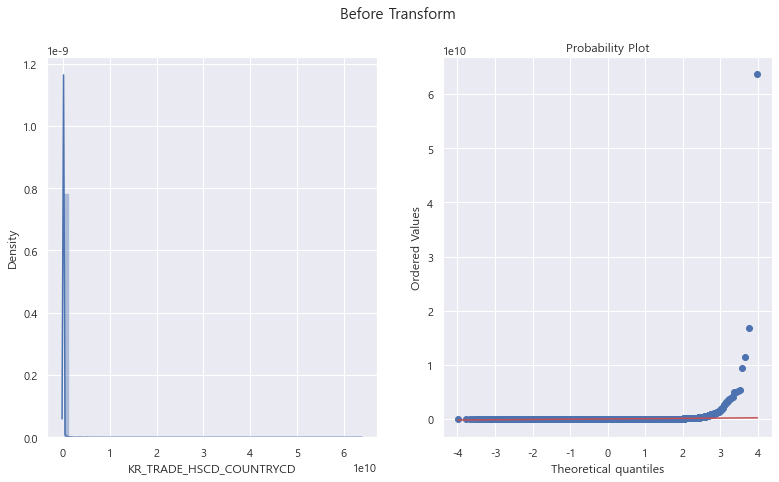

In [6]:
# KR_TRADE_HSCD_COUNTRYCD  분포 파악

figure, axes = plt.subplots(ncols=2, nrows=1)
figure.set_size_inches(13,7)

sns.distplot(data["KR_TRADE_HSCD_COUNTRYCD"], ax=axes[0])
stats.probplot(data["KR_TRADE_HSCD_COUNTRYCD"], dist='norm', fit=True, plot=axes[1])
figure.suptitle("Before Transform" , fontsize = 15)
plt.savefig("KR_TRADE_HSCD_COUNTRYCD_1")

In [7]:
print(data["KR_TRADE_HSCD_COUNTRYCD"].skew())

112.97606789599901


KR_TRADE_HSCD_COUNTRYCD 의 히스토그램(좌측), 정규성그림(우측), skew 값을 확인해보면 분포가 매우 불안정함을 확인할 수 있다.   
분포의 skew 정도를 완화시키기 위해 log 변환이 필요하다. 

C:\Users\82104\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


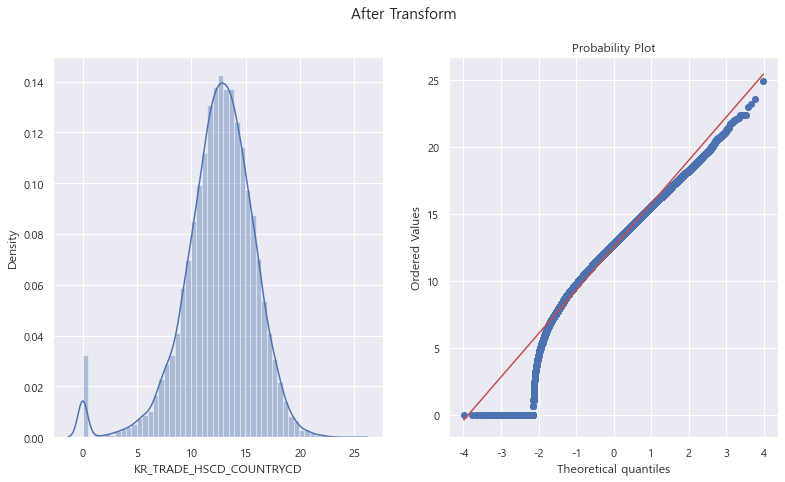

In [8]:
# KR_TRADE_HSCD_COUNTRYCD  분포 파악
figure, axes = plt.subplots(ncols=2, nrows=1)
figure.set_size_inches(13,7)

sns.distplot(np.log1p(data["KR_TRADE_HSCD_COUNTRYCD"]), ax=axes[0])
stats.probplot(np.log1p(data["KR_TRADE_HSCD_COUNTRYCD"]), dist='norm', fit=True, plot=axes[1])
figure.suptitle("After Transform" , fontsize = 15)
plt.savefig("KR_TRADE_HSCD_COUNTRYCD_2")

### 수치형 변수 분포 파악

array([[<AxesSubplot:title={'center':'TRADE_COUNTRYCD'}>,
        <AxesSubplot:title={'center':'TRADE_HSCD'}>,
        <AxesSubplot:title={'center':'TARIFF_AVG'}>],
       [<AxesSubplot:title={'center':'SNDIST'}>,
        <AxesSubplot:title={'center':'NY_GDP_MKTP_CD'}>,
        <AxesSubplot:title={'center':'NY_GDP_MKTP_CD_1Y'}>],
       [<AxesSubplot:title={'center':'SP_POP_TOTL'}>,
        <AxesSubplot:title={'center':'PA_NUS_FCRF'}>,
        <AxesSubplot:title={'center':'IC_BUS_EASE_DFRN_DB'}>],
       [<AxesSubplot:title={'center':'KMDIST'}>,
        <AxesSubplot:title={'center':'TRADE_HSCD_COUNTRYCD'}>,
        <AxesSubplot:>]], dtype=object)

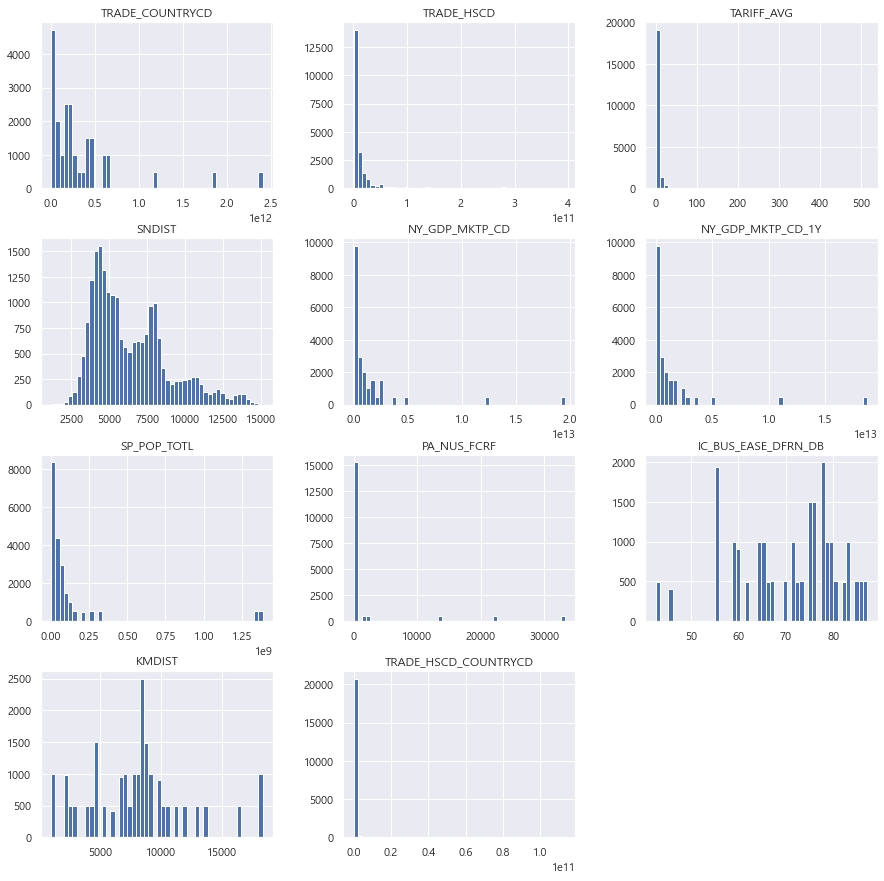

In [9]:
num_data = data.drop(['UNC_YEAR','HSCD','COUNTRYCD','COUNTRYNM','KR_TRADE_HSCD_COUNTRYCD'],axis=1)
num_data.hist(figsize=(15,15) , bins = 50)

In [10]:
print(num_data.skew())

TRADE_COUNTRYCD          2.930884
TRADE_HSCD               6.102355
TARIFF_AVG              16.702626
SNDIST                   0.946287
NY_GDP_MKTP_CD           4.023612
NY_GDP_MKTP_CD_1Y        4.071015
SP_POP_TOTL              3.897461
PA_NUS_FCRF              3.665212
IC_BUS_EASE_DFRN_DB     -0.652442
KMDIST                   0.601956
TRADE_HSCD_COUNTRYCD    29.291836
dtype: float64


대부분의 수치형 변수의 분포가 불안정한 모습을 확인할 수 있다. => log 변환 필요

### 변수 간 연관성 파악

#### 수치형 변수간 연관성 파악 

먼저, 상관계수를 통하여 수치형 변수간의 연관성을 대략적으로 파악해본다.

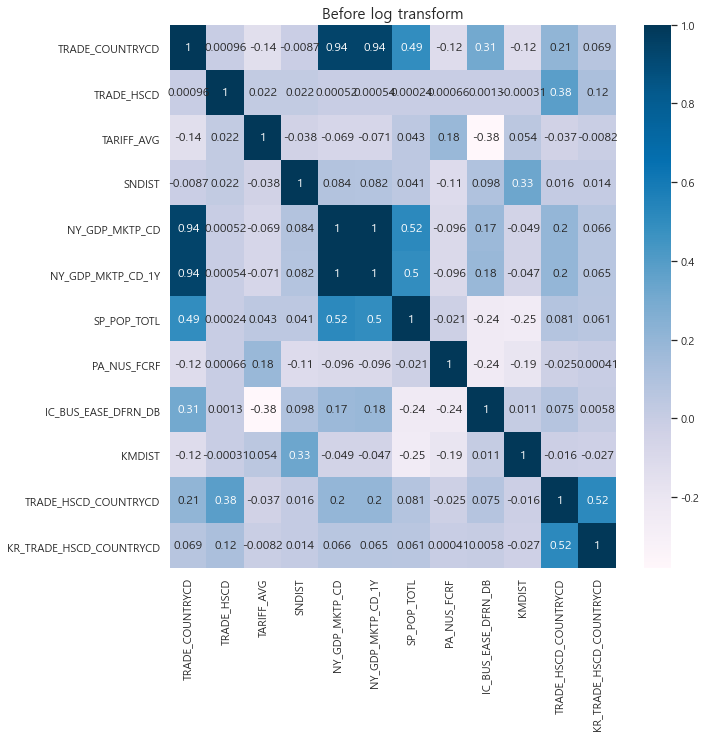

In [11]:
num_data = data.drop(['UNC_YEAR','HSCD','COUNTRYCD','COUNTRYNM'],axis=1)
plt.figure(figsize = (10,10))
plt.title("Before log transform" , fontsize = 15)
sns.heatmap(num_data.corr(), annot = True , cmap="PuBu")
plt.savefig("4")

데이터의 분포의 치우침이 심해 전체적으로 상관계수가 매우 낮은 모습을 확인할 수 있다.   
따라서 로그변환된 데이터를 이용하여 상관계수를 출력한다.

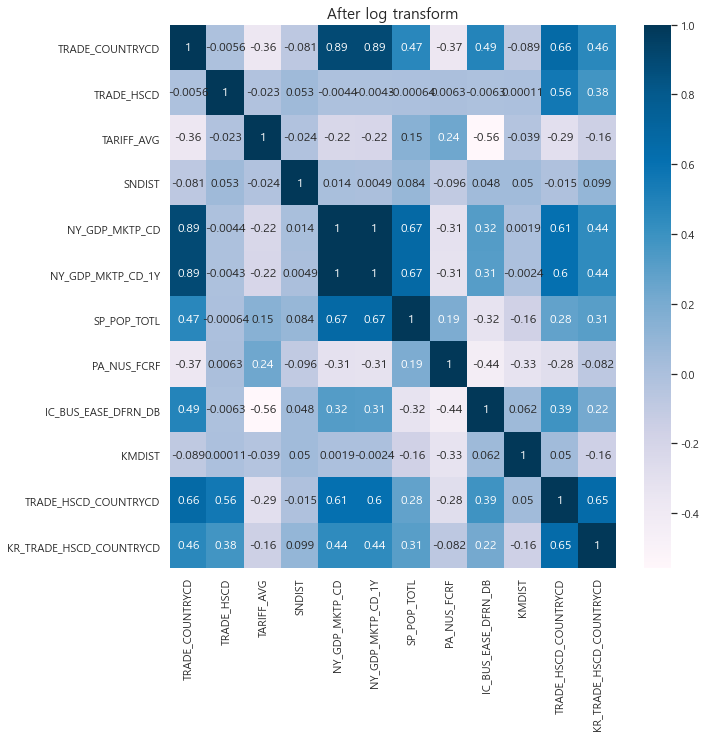

In [12]:
log_num_data = np.log1p(num_data)
plt.figure(figsize = (10,10))
plt.title("After log transform" , fontsize = 15)
sns.heatmap(log_num_data.corr(), annot = True , cmap="PuBu")
plt.savefig("5")

로그 변환을 함으로써 KR_TRADE_HSCD_COUNTRY 와 나머지 변수의 상관계수가 유의하게 높아짐을 확인할 수 있다.   
또한, NY_GDP_MKTP_CD , NY_GDP_MKTP_CD_1Y , TRADE_COUNTRYCD 세 변수의 상관계수가 높아 다중공선성을 유발할 수 있으므로 주의한다.

상관계수는 변수간의 선형 관계만을 파악할 수 있으므로 더욱 구체적인 연관성 파악을 위해 관련성이 높은 변수들의 산점도를 그려본다.

In [13]:
log_num_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21189 entries, 0 to 21188
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TRADE_COUNTRYCD          21189 non-null  float64
 1   TRADE_HSCD               21189 non-null  float64
 2   TARIFF_AVG               21060 non-null  float64
 3   SNDIST                   21167 non-null  float64
 4   NY_GDP_MKTP_CD           21189 non-null  float64
 5   NY_GDP_MKTP_CD_1Y        21189 non-null  float64
 6   SP_POP_TOTL              21189 non-null  float64
 7   PA_NUS_FCRF              17701 non-null  float64
 8   IC_BUS_EASE_DFRN_DB      21189 non-null  float64
 9   KMDIST                   21189 non-null  float64
 10  TRADE_HSCD_COUNTRYCD     21168 non-null  float64
 11  KR_TRADE_HSCD_COUNTRYCD  21189 non-null  float64
dtypes: float64(12)
memory usage: 1.9 MB


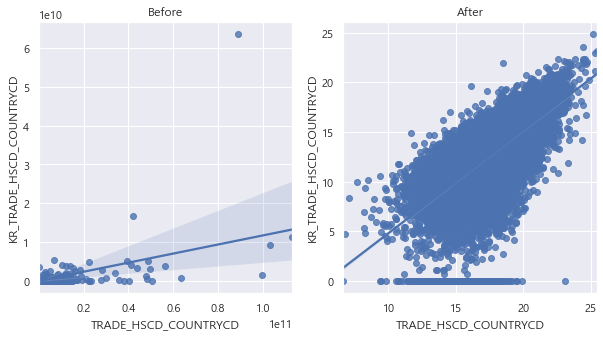

In [14]:
# TRADE_HSCD_COUNTRYCD vs KR_TRADE_HSCD_COUNTRYCD

fig, ax = plt.subplots(ncols=2 , figsize = (10,5))
sns.regplot(x="TRADE_HSCD_COUNTRYCD" , y = "KR_TRADE_HSCD_COUNTRYCD",data=num_data , ax=ax[0] )
ax[0].set(title = "Before")
sns.regplot(x="TRADE_HSCD_COUNTRYCD" , y = "KR_TRADE_HSCD_COUNTRYCD",data=log_num_data , ax=ax[1])
ax[1].set(title = "After")
plt.savefig("scatter")

로그변환에 따라 데이터의 산점도가 확연히 달라짐을 확인할 수 있다. 

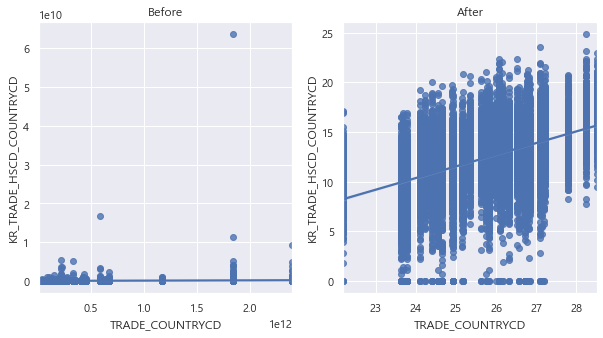

In [15]:
# TRADE_COUNTRYCD vs KR_TRADE_HSCD_COUNTRYCD

fig, ax = plt.subplots(ncols=2 , figsize = (10,5))
sns.regplot(x="TRADE_COUNTRYCD" , y = "KR_TRADE_HSCD_COUNTRYCD",data=num_data , ax=ax[0] )
ax[0].set(title = "Before")
sns.regplot(x="TRADE_COUNTRYCD" , y = "KR_TRADE_HSCD_COUNTRYCD",data=log_num_data , ax=ax[1])
ax[1].set(title = "After")
plt.savefig("7")

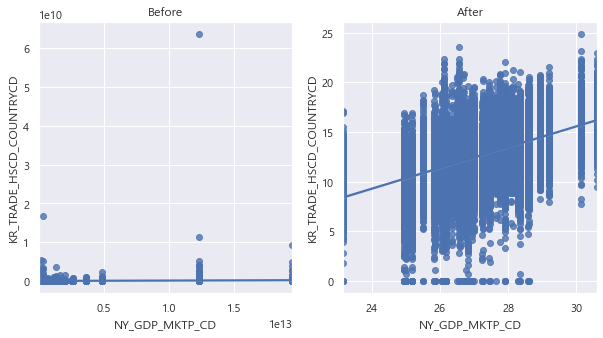

In [16]:
# NY_GDP_MKTP_CD vs KR_TRADE_HSCD_COUNTRYCD

fig, ax = plt.subplots(ncols=2 , figsize = (10,5))
sns.regplot(x="NY_GDP_MKTP_CD" , y = "KR_TRADE_HSCD_COUNTRYCD",data=num_data , ax=ax[0] )
ax[0].set(title = "Before")
sns.regplot(x="NY_GDP_MKTP_CD" , y = "KR_TRADE_HSCD_COUNTRYCD",data=log_num_data , ax=ax[1])
ax[1].set(title = "After")
plt.savefig("8")

#### 범주형 변수와 예측변수의 연관성 파악 

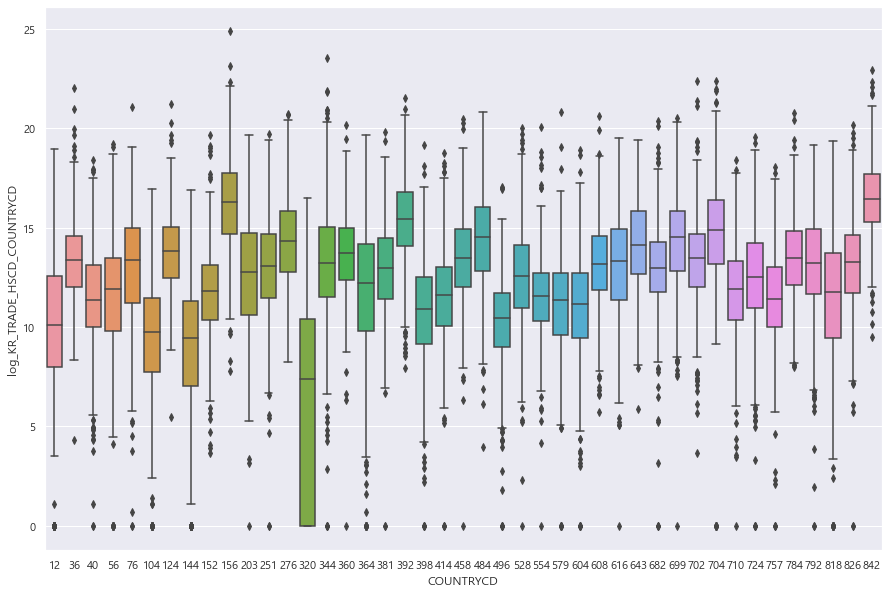

In [17]:
# COUNTRYCD 
data["log_KR_TRADE_HSCD_COUNTRYCD"] = np.log1p(data["KR_TRADE_HSCD_COUNTRYCD"])
plt.figure(figsize = (15,10))
sns.boxplot(data=data, x="COUNTRYCD", y="log_KR_TRADE_HSCD_COUNTRYCD")
plt.savefig("category")

##### 확실히 각 국가별 특성이 KR_TRADE_HSCD_COUNTRYCD 에 영향을 미치는 것을 확인할 수 있다.   

### 결측치 대치 방법 

In [18]:
#PA_NUS_FCRF 결측치 파악 
PA_missing = data[data.PA_NUS_FCRF.isnull() == True]
print("결측치 개수 : ",PA_missing.shape[0])

결측치 개수 :  3488


In [19]:
PA_missing.COUNTRYNM.unique()

array(['Austria', 'Belgium', 'France', 'Germany', 'Italy', 'Netherlands',
       'Spain'], dtype=object)

PA_NUS_FCRF (공식 환율) 결측값인 국가
* Austria
* Belgium
* France
* Germany
* Italy
* Netherlands
* Spain  


이는 모두 유럽연합국가라는 특성을 가진다 => 유럽연합국가의 환율 데이터를 대입하여 결측치 처리  
분석용 데이터에는 2017년도 EUR의 달러 환율 1.13을 대입한다.  
예측용 데이터에는 2018년도 EUR의 공식 환율 1.18을 대입한다.

In [20]:
# SNDIST 결측치 파악 
sn_missing = data[data.SNDIST.isnull() == True]
print("결측치 개수 : ",sn_missing.shape[0])


결측치 개수 :  22


In [21]:
data.SNDIST.skew()

0.9462869042473112

6368.110473540149
2518.0613706424815
5624.930017000001


<AxesSubplot:>

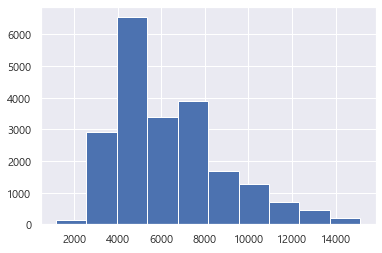

In [22]:
print((data.SNDIST.mean()))
print(data.SNDIST.std())
print(data.SNDIST.median())
data.SNDIST.hist()

SNDIST는 결측치의 갯수가 적고, 분포가 안정적이고 평균과 중앙값이 유사하므로 작업의 효율성을 위해 평균대치법을 사용한다.

In [23]:
#TARIFF_AVG 결측치 파악 
TARIFF_missing = data[data.TARIFF_AVG.isnull() == True]
print("결측치 개수 : ",TARIFF_missing.shape[0])

결측치 개수 :  129


TARIFF_AVG 결측치 처리방법 
1. TARIFF_AVG의 결측치는 세계무역기구 (WTO) 에서 제공하는 국가별, 품목별 관세를 읽어와 평균으로 대치한다.  
2. HSCD 코드가 999999인 품목의 경우, WTO의 데이터에도 값이 없으므로 전체 데이터의 중앙값인 0으로 대치한다.
3. 1,2 에 모두 해당하지 않는 데이터의 경우 해당 국가 유사 품목 (HS 두자리 기준)의 관세 평균으로 대치한다. 




## STEP 2. 사용자 정의 함수

In [24]:
# 모든 결측치 처리 및 추가변수
def missing_data(df,year):
    #명목형 변수 형변환 
    df["HSCD"] = df["HSCD"].map(lambda x: str(x))
    df["COUNTRYCD"] = df["COUNTRYCD"].map(lambda x: str(x))
    
    # PA_NUS_FCRF 결측치 처리 (분석용 기준임)
    if year==2017:
        df.loc[df["PA_NUS_FCRF"].isnull() == True,"PA_NUS_FCRF"] = 1.13
    elif year==2018:
        df.loc[df["PA_NUS_FCRF"].isnull() == True,"PA_NUS_FCRF"] = 1.18
    
    #SNDIST 결측치 처리
    missing_country = df.loc[df.SNDIST.isnull()==True,'COUNTRYNM'].unique()

    for i in missing_country:
        df.loc[(df.SNDIST.isnull()==True)&(df.COUNTRYNM==i),'SNDIST']=df.loc[df.COUNTRYNM==i,'SNDIST'].mean()

In [25]:
# TARIFF_AVG 처리
def TARIFF_AVG_missing(df,year) : 
    hs_2 = [] 
    for i in range(df.shape[0]):
        hs_2.append(df.iloc[i,1][:2])
    df["HS"] = hs_2
    
    ##품목분류 안된 999999코드는 관세 평균을 0으로 대치 
    df.loc[df.HSCD == "999999" ,"TARIFF_AVG"] = 0
    
    ##외부데이터 이용 
    ad_data1 = pd.read_csv("./WtoData_20210629174857.csv")
    ad_data1 = ad_data1[['Reporting Economy','Product/Sector Code','Year','Value']]
    ad_data1.columns = ['COUNTRYNM',"HS","Year","tariff"]
    ad_data1["HS"] = ad_data1["HS"].map(lambda x: str(x))
    
    ## 추가 데이터 국가명 다른 부분 해결 
    ad_data1.loc[ad_data1.COUNTRYNM=='Hong Kong, China','COUNTRYNM']='China, Hong Kong SAR'
    ad_data1.loc[ad_data1.COUNTRYNM=='Saudi Arabia, Kingdom of','COUNTRYNM']='Saudi Arabia'
    ad_data1.loc[ad_data1.COUNTRYNM=='United States of America','COUNTRYNM']='USA'
    
    if year==2017:
        ad_data1=ad_data1[ad_data1.Year==2017] 
    else: ad_data1=ad_data1[ad_data1.Year==2018]
    
    ad_data1.loc[ad_data1.tariff.isnull()==True,'tariff'] = 0
    
    data2 = df[df.TARIFF_AVG.isnull()==True]
    merge = pd.merge(data2,ad_data1, how="left", left_on=['HS','COUNTRYNM'], right_on=['HS','COUNTRYNM'])
    merge.loc[:,'TARIFF_AVG']=merge.tariff
    
    
    EU = ['Austria', 'Belgium', 'France', 'Germany', 'Italy', 'Netherlands','Spain']
    tariff_missing=merge[merge.TARIFF_AVG.isnull()==True]
    test=tariff_missing.COUNTRYNM.isin(EU)
    
    HS= [] 
    for i in test.index:
        if test[i]==True:
            HS.append(tariff_missing.HS[i])
            
    HS1=np.array(HS)
    HS2=pd.DataFrame(HS1)
    Euro_HS=HS2[0].unique()
    
    # 유로국가이면서 평균관세가 결측치인 품목들을 기존 데이터들의 자료를 인용하여 대치한다.
    for i in Euro_HS:
        masking= (merge.TARIFF_AVG.isnull()==True) & (merge.COUNTRYNM.isin(EU)) & (merge.HS==i)
        merge.loc[masking,'TARIFF_AVG'] = ad_data1.loc[(ad_data1.COUNTRYNM=='European Union') & (ad_data1.HS==i),'tariff'].values[0]
    
    merge[merge.TARIFF_AVG.isnull()==True]
    merge=merge[['HSCD','COUNTRYNM','TARIFF_AVG']]
    merge.columns=['HSCD','COUNTRYNM','Imputate']
    
    data2=pd.merge(df,merge,how='left',left_on=['HSCD','COUNTRYNM'],right_on=['HSCD','COUNTRYNM'])
    data2.loc[data2.TARIFF_AVG.isnull()==True,'TARIFF_AVG']=data2.loc[data2.TARIFF_AVG.isnull()==True,'Imputate']
    data2 = data2.drop('Imputate',axis=1)

    tt=data2.loc[data2.TARIFF_AVG.isnull()==True,['COUNTRYNM','HS']]
    maskout=(data2.TARIFF_AVG.isnull()==True)
    

    for i,j in zip(tt.COUNTRYNM,tt.HS):
        maskfor=(data2.COUNTRYNM==i)&(data2.HS==j)
        data2.loc[maskout&(maskfor),'TARIFF_AVG'] = data2.loc[maskfor,'TARIFF_AVG'].mean()
    
    return data2

In [26]:
## 2017년 자료
def read_2017_i(df):
    file_=os.listdir("./2017_import")
    file_path_1="./2017_import"

    i_res=pd.DataFrame()
    for i in range(1,len(file_)+1):
        filename = "comtrade (" + str(i) + ").csv"
        filepath = file_path_1 + '/' + filename
        tem = pd.read_csv(filepath)
        tem = tem[["Reporter","Commodity Code","Trade Value (US$)","Mode of Transport","Customs","2nd Partner"]]
        tem = tem[(tem["Mode of Transport"]=="All MOTs")]
        tem = tem[tem["Customs"]=="All CPCs"]
        tem = tem[tem["2nd Partner"] == "World"]
        tem.columns = ["COUNTRYNM","HSCD","i_KR_TRADE_HSCD_COUNTRYCD","type","type2","type3"]
    
        tem["HSCD"] = tem["HSCD"].map(lambda x: str(x))
    
        i_res = pd.concat([i_res,tem])

    i_res = i_res.reset_index().drop(["index","type","type2","type3"],axis=1)
    res=pd.merge(df,i_res,how='left', left_on=["COUNTRYNM","HSCD"], right_on=["COUNTRYNM","HSCD"])
    return res

def read_2017_e(df):
    file_=os.listdir("./2017_export")
    file_path_1="./2017_export"

    e_res=pd.DataFrame()
    for i in range(1,len(file_)+1):
        filename = "comtrade (" + str(i) + ").csv"
        filepath = file_path_1 + '/' + filename
        tem = pd.read_csv(filepath)
        tem = tem[["Partner","Commodity Code","Trade Value (US$)","Mode of Transport","Customs","2nd Partner"]]
        tem = tem[(tem["Mode of Transport"]=="All MOTs")]
        tem = tem[tem["Customs"]=="All CPCs"]
        tem = tem[tem["2nd Partner"] == "World"]
        tem.columns = ["COUNTRYNM","HSCD","e_KR_TRADE_HSCD_COUNTRYCD","type","type2","type3"]
    
        tem["HSCD"] = tem["HSCD"].map(lambda x: str(x))
    
        e_res = pd.concat([e_res,tem])

    e_res = e_res.reset_index().drop(["index","type","type2","type3"],axis=1)
    res=pd.merge(df,e_res,how='left', left_on=["COUNTRYNM","HSCD"], right_on=["COUNTRYNM","HSCD"])
    return res

In [27]:
def imputate_KR(a,b,c):
    if (c not in except_country):
        if a!=-99:
            return a
        elif (a==-99)&(b!=-99):
            return b
        else:
            return 0
    else:
        if b!=-99:
            return b
        else : 
            return 0

In [28]:
def feature_engineering (df,year):
    if year==2017:       
        # 해당 국가가 자료수집 간 예외 국가인지 식별 변수
        df["Except_country"]=0
        except_country=['Guatemala','Viet Nam','Iran','Egypt']
        df.loc[df['COUNTRYNM'].isin(except_country),'Except_country']=1
    
        # 품목 2자리 변수가 84 그룹과 85 그룹인지 확인하는 변수 
        df['HS_84_85']=0
        df.loc[((df['HS']==85)|(df['HS']==84)),'HS_84_85']=1
    
        df['HS_84_85']=df['HS_84_85'].astype('object')
        df['Except_country']=df['Except_country'].astype('object')
        # 작년도와 이번년도 GDP 비
        df["GDP_RATIO"]=df["NY_GDP_MKTP_CD"]/df["NY_GDP_MKTP_CD_1Y"]
        # 한국까지의 평균 거리와 수입국가간 평균 거리의 비
        df["RDIST"]=df['SNDIST']/df['KMDIST']
    
        # 모든 품목의 수입액 중에 특정 품목이 차지하는 비율
        df['HSCD_RATIO']=df['TRADE_HSCD']/df['TRADE_HSCD'].unique().sum()
        # 모든 국가의 수입액 중에 특정 국가가 차지하는 비율
        df['COUNTRY_RATIO']=df['TRADE_COUNTRYCD']/df['TRADE_COUNTRYCD'].unique().sum()
        # 특정 품목의 수입액 중에 특정 국가가 차지하는 비율
        df['TRADE_RATIO']=df['TRADE_HSCD_COUNTRYCD']/df['TRADE_HSCD']
        # 특정 품목의 수입액 중에 한국 수입액이 차지하는 비율
        for i in df['HSCD'].unique():
            temp=df.loc[df['HSCD']==i,['KR_2017','TRADE_HSCD']]
            temp['temp']=temp['KR_2017'].sum()/temp['TRADE_HSCD'].unique()[0]
            df.loc[df['HSCD']==i,'KR_HSCD_RATIO']=temp['temp']
        
        # 특정 국가의 수입액 중에 한국 수입액이 차지하는 비율
        for i in df['COUNTRYCD'].unique():
            temp=df.loc[df['COUNTRYCD']==i,['KR_2017','TRADE_COUNTRYCD']]
            temp['temp']=temp['KR_2017'].sum()/temp['TRADE_COUNTRYCD'].unique()[0]
            df.loc[df['COUNTRYCD']==i,'KR_COUNTRY_RATIO']=temp['temp']
        
        # 특정 국가의 특정 품목 수입액 중에 한국 수입액이 차지하는 비율
        df['KR_HSCD_COUNTRY_RATIO']=df['KR_2017']/df['TRADE_HSCD_COUNTRYCD']
    
        # 특정 국가의 한국 수입액 중에 특정 품목이 차지하는 비율
        for i in df['COUNTRYCD'].unique():
            temp=df.loc[df['COUNTRYCD']==i,['KR_2017']]
            temp['temp']=temp['KR_2017']/temp['KR_2017'].sum()
            df.loc[df['COUNTRYCD']==i,'KR_RATIO']=temp['temp']
    
        # 특정 국가의 수입액 중에 특정 품목이 차지하는 비율
        for i in df['COUNTRYCD'].unique():
            temp=df.loc[df['COUNTRYCD']==i,['TRADE_HSCD_COUNTRYCD','TRADE_COUNTRYCD']]
            temp['temp']=temp['TRADE_HSCD_COUNTRYCD']/temp['TRADE_COUNTRYCD'].unique()[0]
            df.loc[df['COUNTRYCD']==i,'TRADE_HSCD_RATIO']=temp['temp']
    else :
        # 해당 국가가 자료수집 간 예외 국가인지 식별 변수
        df["Except_country"]=0
        except_country=['Guatemala','Viet Nam','Iran','Egypt']
        df.loc[df['COUNTRYNM'].isin(except_country),'Except_country']=1
    
        # 품목 2자리 변수가 84 그룹과 85 그룹인지 확인하는 변수 
        df['HS_84_85']=0
        df.loc[((df['HS']==85)|(df['HS']==84)),'HS_84_85']=1
    
        df['HS_84_85']=df['HS_84_85'].astype('object')
        df['Except_country']=df['Except_country'].astype('object')
        
        # 작년도와 이번년도 GDP 비
        df["GDP_RATIO"]=df["NY_GDP_MKTP_CD"]/df["NY_GDP_MKTP_CD_1Y"]
        # 한국까지의 평균 거리와 수입국가간 평균 거리의 비
        df["RDIST"]=df['SNDIST']/df['KMDIST']
    
        # 모든 품목의 수입액 중에 특정 품목이 차지하는 비율
        df['HSCD_RATIO']=df['TRADE_HSCD']/df['TRADE_HSCD'].unique().sum()
        # 모든 국가의 수입액 중에 특정 국가가 차지하는 비율
        df['COUNTRY_RATIO']=df['TRADE_COUNTRYCD']/df['TRADE_COUNTRYCD'].unique().sum()
        # 특정 품목의 수입액 중에 특정 국가가 차지하는 비율
        df['TRADE_RATIO']=df['TRADE_HSCD_COUNTRYCD']/df['TRADE_HSCD']
        # 특정 품목의 수입액 중에 한국 수입액이 차지하는 비율
        for i in df['HSCD'].unique():
            temp=df.loc[df['HSCD']==i,['KR_2018','TRADE_HSCD']]
            temp['temp']=temp['KR_2018'].sum()/temp['TRADE_HSCD'].unique()[0]
            df.loc[df['HSCD']==i,'KR_HSCD_RATIO']=temp['temp']
        
        #  특정 국가의 수입액 중에 한국 수입액이 차지하는 비율
        for i in df['COUNTRYCD'].unique():
            temp=df.loc[df['COUNTRYCD']==i,['KR_2018','TRADE_COUNTRYCD']]
            temp['temp']=temp['KR_2018'].sum()/temp['TRADE_COUNTRYCD'].unique()[0]
            df.loc[df['COUNTRYCD']==i,'KR_COUNTRY_RATIO']=temp['temp']
        
        # 특정 국가의 특정 품목 수입액 중에 한국 수입액이 차지하는 비율
        df['KR_HSCD_COUNTRY_RATIO']=df['KR_2018']/df['TRADE_HSCD_COUNTRYCD']
    
        # 특정 국가의 한국 수입액 중에 특정 품목이 차지하는 비율
        for i in df['COUNTRYCD'].unique():
            temp=df.loc[df['COUNTRYCD']==i,['KR_2018']]
            temp['temp']=temp['KR_2018']/temp['KR_2018'].sum()
            df.loc[df['COUNTRYCD']==i,'KR_RATIO']=temp['temp']
    
        # 특정 국가의 수입액 중에 특정 품목이 차지하는 비율
        for i in df['COUNTRYCD'].unique():
            temp=df.loc[df['COUNTRYCD']==i,['TRADE_HSCD_COUNTRYCD','TRADE_COUNTRYCD']]
            temp['temp']=temp['TRADE_HSCD_COUNTRYCD']/temp['TRADE_COUNTRYCD'].unique()[0]
            df.loc[df['COUNTRYCD']==i,'TRADE_HSCD_RATIO']=temp['temp']    

In [29]:
def add_FTA(df):
    FTA = pd.read_excel("./국가별FTA체결현황.xlsx")
    df=pd.merge(df,FTA,how='left',left_on='COUNTRYNM',right_on='country')
    df["FTA"] = df["FTA"].astype(object)
    df=df.drop(['country'],axis=1)
    return df

In [30]:
def add_group(df):
    ex = pd.read_excel("./2019년_HS_신성질별 성질별 연계(홈페이지 게재용) .xlsx",sheet_name="Sheet4")
    ex = ex[["6자리","현행수출1단위분류"]]
    ex = ex[ex["6자리"] > 99999]

    ex.columns = ["hscd","group"]
    for i in range(ex.shape[0]):
        if ex.iloc[i,1] == "1. 식료 및 직접소비재":
            ex.iloc[i,1] = "1"
        elif ex.iloc[i,1] == "2. 원료 및 연료":
            ex.iloc[i,1] = "2"
        elif ex.iloc[i,1] == "3. 경공업품":
            ex.iloc[i,1] = "3"
        elif ex.iloc[i,1] == "4. 중화학 공업품":
            ex.iloc[i,1] = "4"

    ex1 = ex.drop_duplicates(["hscd"])
    df['HSCD']=df['HSCD'].astype('int64')
    df = pd.merge(df,ex1,how="left",left_on='HSCD',right_on="hscd")
    df = df.drop("hscd",axis=1)
    df.loc[df.group.isnull()==True,'group']='5'
    df['HSCD']=df['HSCD'].astype(object)
    return df

def income_group(df):
    income=pd.read_csv("./Metadata_Country_API_PA.NUS.FCRF_DS2_en_csv_v2_2445345.csv")
    income=income[['IncomeGroup','TableName']]
    
    income.loc[income.TableName=='Czech Republic','TableName']='Czechia'
    income.loc[income.TableName=='Hong Kong SAR, China','TableName']='China, Hong Kong SAR'
    income.loc[income.TableName=='Iran, Islamic Rep.','TableName']='Iran'
    income.loc[income.TableName=='Vietnam','TableName']='Viet Nam'
    income.loc[income.TableName=='Egypt, Arab Rep.','TableName']='Egypt'
    income.loc[income.TableName=='United States','TableName']='USA'

    df=pd.merge(df,income,how='left',left_on='COUNTRYNM',right_on='TableName')
    df=df.drop("TableName",axis=1)
    return df


In [31]:
def variable_to_group(df):
    df['dist']=pd.qcut(df['SNDIST'],3,labels=[1,3,5])

    df['TARIFF']=0
    df.loc[df['TARIFF_AVG']>0,'TARIFF']=1

    df['PA']=pd.qcut(df['PA_NUS_FCRF'],2,labels=[0,1])

    df['BE']=pd.qcut(df['IC_BUS_EASE_DFRN_DB'],3,labels=[1,3,5])
    df['TARIFF']=df['TARIFF'].astype('category')

## STEP 3. 데이터 전처리 및 특성 공학

In [32]:
data = pd.read_csv('./공모전데이터_분석용_KOTRA_0525.csv')

In [33]:
missing_data(data,2017)

data =TARIFF_AVG_missing(data,2017)
data = read_2017_i(data)
data = read_2017_e(data)

except_country=['Guatemala','Viet Nam','Iran','Egypt']

data.loc[data["i_KR_TRADE_HSCD_COUNTRYCD"].isnull() == True,"i_KR_TRADE_HSCD_COUNTRYCD"] = -99
data.loc[data["e_KR_TRADE_HSCD_COUNTRYCD"].isnull() == True,"e_KR_TRADE_HSCD_COUNTRYCD"] = -99

data["KR_2017"] = data.apply(lambda x: imputate_KR(x["i_KR_TRADE_HSCD_COUNTRYCD"],x["e_KR_TRADE_HSCD_COUNTRYCD"],x["COUNTRYNM"]),axis=1)

data = data.drop(["i_KR_TRADE_HSCD_COUNTRYCD","e_KR_TRADE_HSCD_COUNTRYCD"],axis=1)


In [34]:
feature_engineering(data,2017)
data=add_FTA(data)
data=add_group(data)
data=income_group(data)
variable_to_group(data)

data=data.reset_index().drop('index',axis=1)

## STEP 4. TRADE_HSCD_COUNTRYCD XGBR 회귀 추정 및 대치 

In [35]:
model_data=data.drop(['UNC_YEAR','COUNTRYCD','TRADE_RATIO','KR_HSCD_COUNTRY_RATIO','TRADE_HSCD_RATIO'],axis=1)

In [36]:
model_data=data.drop(['UNC_YEAR','COUNTRYCD','TRADE_RATIO','KR_HSCD_COUNTRY_RATIO','TRADE_HSCD_RATIO'],axis=1)
model_data = model_data[model_data["TRADE_HSCD_COUNTRYCD"].isnull() == False]

In [37]:
new=data[['TRADE_COUNTRYCD', 'TRADE_HSCD', 'TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST', 'HSCD_RATIO','COUNTRY_RATIO','TRADE_HSCD_COUNTRYCD','KR_TRADE_HSCD_COUNTRYCD']]
mask = ((new['KR_TRADE_HSCD_COUNTRYCD']==0)&(new['KR_2017']!=0))|((new['KR_TRADE_HSCD_COUNTRYCD']!=0)&(new['KR_2017']==0)) 

### 41

In [38]:
model_c=new[~mask]
x_pred_41=model_c[model_c['TRADE_HSCD_COUNTRYCD'].isnull()==True]
index=x_pred_41.index
model_c=model_c[model_c['TRADE_HSCD_COUNTRYCD'].isnull()==False]
model_c=model_c.reset_index().drop('index',axis=1)
y=model_c["TRADE_HSCD_COUNTRYCD"]
x=model_c.drop("TRADE_HSCD_COUNTRYCD",axis=1)
x2=x[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB', 'KR_2017', 'RDIST', 'HSCD_RATIO']]
x_pred_41=x_pred_41[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB', 'KR_2017', 'RDIST', 'HSCD_RATIO']]
name=x2.columns
x2=np.log1p(x2)
x_pred_41=np.log1p(x_pred_41)
y=np.log1p(y)
ss41=StandardScaler()
ss41.fit(x2)
x_num=ss41.transform(x2)
x_pred_41=ss41.transform(x_pred_41)
x=pd.DataFrame(x_num)
x.columns=list(name)
x_pred_41=pd.DataFrame(x_pred_41,index=index)
x_pred_41.columns=list(name)


x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=41)


xgbr41=XGBRegressor(random_state=42)
xgbr41.fit(x_train,y_train)

model_compare=new[['TRADE_COUNTRYCD','TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KR_2017','RDIST', 'HSCD_RATIO','TRADE_HSCD_COUNTRYCD']]
model_compare=model_compare[model_compare['TRADE_HSCD_COUNTRYCD'].isnull()==False]
model_compare=model_compare.reset_index().drop('index',axis=1)
y_c=model_compare["TRADE_HSCD_COUNTRYCD"]
x_c=model_compare.drop("TRADE_HSCD_COUNTRYCD",axis=1)
x2_c=x_c[['TRADE_COUNTRYCD','TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KR_2017','RDIST', 'HSCD_RATIO']]
name=x2.columns
x2_c=np.log1p(x2_c)
y_c=np.log1p(y_c)
x_num_c=ss41.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)
    
pred_41=xgbr41.predict(x_c)
rmse_41=np.sqrt((((np.expm1(y_c)-np.expm1(pred_41))**2).sum())/len(pred_41))

### 42

In [39]:
model_c=new[~mask]
x_pred_42=model_c[model_c['TRADE_HSCD_COUNTRYCD'].isnull()==True]
index=x_pred_42.index
model_c=model_c[model_c['TRADE_HSCD_COUNTRYCD'].isnull()==False]
model_c=model_c.reset_index().drop('index',axis=1)
y=model_c["TRADE_HSCD_COUNTRYCD"]
x=model_c.drop("TRADE_HSCD_COUNTRYCD",axis=1)
x2=x[['TRADE_COUNTRYCD', 'TRADE_HSCD', 'TARIFF_AVG', 'SNDIST', 'PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST']]
x_pred_42=x_pred_42[['TRADE_COUNTRYCD', 'TRADE_HSCD', 'TARIFF_AVG', 'SNDIST', 'PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST']]
name=x2.columns
x2=np.log1p(x2)
x_pred_42=np.log1p(x_pred_42)
y=np.log1p(y)
ss42=StandardScaler()
ss42.fit(x2)
x_num=ss42.transform(x2)
x_pred_42=ss42.transform(x_pred_42)
x=pd.DataFrame(x_num)
x.columns=list(name)
x_pred_42=pd.DataFrame(x_pred_42,index=index)
x_pred_42.columns=list(name)
    
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)


xgbr42=XGBRegressor(random_state=42)
xgbr42.fit(x_train,y_train)

model_compare=new[['TRADE_COUNTRYCD', 'TRADE_HSCD', 'TARIFF_AVG', 'SNDIST','PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST','TRADE_HSCD_COUNTRYCD']]
model_compare=model_compare[model_compare['TRADE_HSCD_COUNTRYCD'].isnull()==False]
model_compare=model_compare.reset_index().drop('index',axis=1)
y_c=model_compare["TRADE_HSCD_COUNTRYCD"]
x_c=model_compare.drop("TRADE_HSCD_COUNTRYCD",axis=1)
x2_c=x_c[['TRADE_COUNTRYCD', 'TRADE_HSCD', 'TARIFF_AVG', 'SNDIST','PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST']]
name=x2.columns
x2_c=np.log1p(x2_c)
y_c=np.log1p(y_c)
x_num_c=ss42.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)
    
pred_42=xgbr42.predict(x_c)
rmse_42=np.sqrt((((np.expm1(y_c)-np.expm1(pred_42))**2).sum())/len(pred_42))

### 43

In [40]:
model_c=new[~mask]
x_pred_43=model_c[model_c['TRADE_HSCD_COUNTRYCD'].isnull()==True]
index=x_pred_43.index
model_c=model_c[model_c['TRADE_HSCD_COUNTRYCD'].isnull()==False]
model_c=model_c.reset_index().drop('index',axis=1)
y=model_c["TRADE_HSCD_COUNTRYCD"]
x=model_c.drop("TRADE_HSCD_COUNTRYCD",axis=1)
x2=x[['TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST', 'HSCD_RATIO','COUNTRY_RATIO']]
x_pred_43=x_pred_43[['TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST', 'HSCD_RATIO','COUNTRY_RATIO']]
name=x2.columns
x2=np.log1p(x2)
x_pred_43=np.log1p(x_pred_43)
y=np.log1p(y)
ss43=StandardScaler()
ss43.fit(x2)
x_num=ss43.transform(x2)
x_pred_43=ss43.transform(x_pred_43)
x=pd.DataFrame(x_num)
x.columns=list(name)
x_pred_43=pd.DataFrame(x_pred_43,index=index)
x_pred_43.columns=list(name)
    
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=43)


xgbr43=XGBRegressor(random_state=42)
xgbr43.fit(x_train,y_train)

model_compare=new[['TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD', 'SP_POP_TOTL','IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST', 'HSCD_RATIO','COUNTRY_RATIO','TRADE_HSCD_COUNTRYCD']]
model_compare=model_compare[model_compare['TRADE_HSCD_COUNTRYCD'].isnull()==False]
model_compare=model_compare.reset_index().drop('index',axis=1)
y_c=model_compare["TRADE_HSCD_COUNTRYCD"]
x_c=model_compare.drop("TRADE_HSCD_COUNTRYCD",axis=1)
x2_c=x_c[['TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD', 'SP_POP_TOTL','IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST', 'HSCD_RATIO','COUNTRY_RATIO']]
name=x2.columns
x2_c=np.log1p(x2_c)
y_c=np.log1p(y_c)
x_num_c=ss43.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)
    
pred_43=xgbr43.predict(x_c)
rmse_43=np.sqrt((((np.expm1(y_c)-np.expm1(pred_43))**2).sum())/len(pred_43))

### 44

In [41]:
model_c=new[~mask]
x_pred_44=model_c[model_c['TRADE_HSCD_COUNTRYCD'].isnull()==True]
index=x_pred_44.index
model_c=model_c[model_c['TRADE_HSCD_COUNTRYCD'].isnull()==False]
model_c=model_c.reset_index().drop('index',axis=1)
y=model_c["TRADE_HSCD_COUNTRYCD"]
x=model_c.drop("TRADE_HSCD_COUNTRYCD",axis=1)
x2=x[['TRADE_HSCD', 'TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD','IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO','COUNTRY_RATIO']]
x_pred_44=x_pred_44[['TRADE_HSCD', 'TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD','IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO','COUNTRY_RATIO']]
name=x2.columns
x2=np.log1p(x2)
x_pred_44=np.log1p(x_pred_44)
y=np.log1p(y)
ss44=StandardScaler()
ss44.fit(x2)
x_num=ss44.transform(x2)
x_pred_44=ss44.transform(x_pred_44)
x=pd.DataFrame(x_num)
x.columns=list(name)
x_pred_44=pd.DataFrame(x_pred_44,index=index)
x_pred_44.columns=list(name)

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=44)


xgbr44=XGBRegressor(random_state=42)
xgbr44.fit(x_train,y_train)

model_compare=new[['TRADE_HSCD', 'TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD','IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO','COUNTRY_RATIO','TRADE_HSCD_COUNTRYCD']]
model_compare=model_compare[model_compare['TRADE_HSCD_COUNTRYCD'].isnull()==False]
model_compare=model_compare.reset_index().drop('index',axis=1)
y_c=model_compare["TRADE_HSCD_COUNTRYCD"]
x_c=model_compare.drop("TRADE_HSCD_COUNTRYCD",axis=1)
x2_c=x_c[['TRADE_HSCD', 'TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD','IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO','COUNTRY_RATIO']]
name=x2.columns
x2_c=np.log1p(x2_c)
y_c=np.log1p(y_c)
x_num_c=ss44.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)
    
pred_44=xgbr44.predict(x_c)
rmse_44=np.sqrt((((np.expm1(y_c)-np.expm1(pred_44))**2).sum())//len(pred_44))

### 45

In [42]:
model_c=new[~mask]
x_pred_45=model_c[model_c['TRADE_HSCD_COUNTRYCD'].isnull()==True]
index=x_pred_45.index
model_c=model_c[model_c['TRADE_HSCD_COUNTRYCD'].isnull()==False]
model_c=model_c.reset_index().drop('index',axis=1)
y=model_c["TRADE_HSCD_COUNTRYCD"]
x=model_c.drop("TRADE_HSCD_COUNTRYCD",axis=1)
x2=x[['TRADE_HSCD','SNDIST','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST','COUNTRY_RATIO']]
x_pred_45=x_pred_45[['TRADE_HSCD','SNDIST','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST','COUNTRY_RATIO']]
name=x2.columns
x2=np.log1p(x2)
x_pred_45=np.log1p(x_pred_45)
y=np.log1p(y)
ss45=StandardScaler()
ss45.fit(x2)
x_num=ss45.transform(x2)
x_pred_45=ss45.transform(x_pred_45)
x=pd.DataFrame(x_num)
x.columns=list(name)
x_pred_45=pd.DataFrame(x_pred_45,index=index)
x_pred_45.columns=list(name)
    
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=45)


xgbr45=XGBRegressor(random_state=42)
xgbr45.fit(x_train,y_train)

model_compare=new[['TRADE_HSCD','SNDIST','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST','COUNTRY_RATIO','TRADE_HSCD_COUNTRYCD']]
model_compare=model_compare[model_compare['TRADE_HSCD_COUNTRYCD'].isnull()==False]
model_compare=model_compare.reset_index().drop('index',axis=1)
y_c=model_compare["TRADE_HSCD_COUNTRYCD"]
x_c=model_compare.drop("TRADE_HSCD_COUNTRYCD",axis=1)
x2_c=x_c[['TRADE_HSCD','SNDIST','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST','COUNTRY_RATIO']]
name=x2.columns
x2_c=np.log1p(x2_c)
y_c=np.log1p(y_c)
x_num_c=ss45.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)
    
pred_45=xgbr45.predict(x_c)
rmse_45=np.sqrt((((np.expm1(y_c)-np.expm1(pred_45))**2).sum())//len(pred_45))

### 46

In [43]:
model_c=new[~mask]
x_pred_46=model_c[model_c['TRADE_HSCD_COUNTRYCD'].isnull()==True]
index=x_pred_46.index
model_c=model_c[model_c['TRADE_HSCD_COUNTRYCD'].isnull()==False]
model_c=model_c.reset_index().drop('index',axis=1)
y=model_c["TRADE_HSCD_COUNTRYCD"]
x=model_c.drop("TRADE_HSCD_COUNTRYCD",axis=1)
x2=x[['TARIFF_AVG','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST', 'HSCD_RATIO','COUNTRY_RATIO']]
x_pred_46=x_pred_46[['TARIFF_AVG','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST', 'HSCD_RATIO','COUNTRY_RATIO']]
name=x2.columns
x2=np.log1p(x2)
x_pred_46=np.log1p(x_pred_46)
y=np.log1p(y)
ss46=StandardScaler()
ss46.fit(x2)
x_num=ss46.transform(x2)
x_pred_46=ss46.transform(x_pred_46)
x=pd.DataFrame(x_num)
x.columns=list(name)
x_pred_46=pd.DataFrame(x_pred_46,index=index)
x_pred_46.columns=list(name)
    
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=46)


xgbr46=XGBRegressor(random_state=42)
xgbr46.fit(x_train,y_train)

model_compare=new[['TARIFF_AVG','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST', 'HSCD_RATIO','COUNTRY_RATIO','TRADE_HSCD_COUNTRYCD']]
model_compare=model_compare[model_compare['TRADE_HSCD_COUNTRYCD'].isnull()==False]
model_compare=model_compare.reset_index().drop('index',axis=1)
y_c=model_compare["TRADE_HSCD_COUNTRYCD"]
x_c=model_compare.drop("TRADE_HSCD_COUNTRYCD",axis=1)
x2_c=x_c[['TARIFF_AVG','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST', 'HSCD_RATIO','COUNTRY_RATIO']]
name=x2.columns
x2_c=np.log1p(x2_c)
y_c=np.log1p(y_c)
x_num_c=ss46.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)
    
pred_46=xgbr46.predict(x_c)
rmse_46=np.sqrt((((np.expm1(y_c)-np.expm1(pred_46))**2).sum())/len(pred_46))

### 47

In [44]:
model_c=new[~mask]
x_pred_47=model_c[model_c['TRADE_HSCD_COUNTRYCD'].isnull()==True]
index=x_pred_47.index
model_c=model_c[model_c['TRADE_HSCD_COUNTRYCD'].isnull()==False]
model_c=model_c.reset_index().drop('index',axis=1)
y=model_c["TRADE_HSCD_COUNTRYCD"]
x=model_c.drop("TRADE_HSCD_COUNTRYCD",axis=1)
x2=x[['TRADE_HSCD', 'TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD','PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST','COUNTRY_RATIO']]
x_pred_47=x_pred_47[['TRADE_HSCD', 'TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD','PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST','COUNTRY_RATIO']]
name=x2.columns
x2=np.log1p(x2)
x_pred_47=np.log1p(x_pred_47)
y=np.log1p(y)
ss47=StandardScaler()
ss47.fit(x2)
x_num=ss47.transform(x2)
x_pred_47=ss47.transform(x_pred_47)
x=pd.DataFrame(x_num)
x.columns=list(name)
x_pred_47=pd.DataFrame(x_pred_47,index=index)
x_pred_47.columns=list(name)
    
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=47)


xgbr47=XGBRegressor(random_state=42)
xgbr47.fit(x_train,y_train)

model_compare=new[['TRADE_HSCD', 'TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD','PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST','COUNTRY_RATIO','TRADE_HSCD_COUNTRYCD']]
model_compare=model_compare[model_compare['TRADE_HSCD_COUNTRYCD'].isnull()==False]
model_compare=model_compare.reset_index().drop('index',axis=1)
y_c=model_compare["TRADE_HSCD_COUNTRYCD"]
x_c=model_compare.drop("TRADE_HSCD_COUNTRYCD",axis=1)
x2_c=x_c[['TRADE_HSCD', 'TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD','PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST','COUNTRY_RATIO']]
name=x2.columns
x2_c=np.log1p(x2_c)
y_c=np.log1p(y_c)
x_num_c=ss47.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)
    
pred_47=xgbr47.predict(x_c)
rmse_47=np.sqrt((((np.expm1(y_c)-np.expm1(pred_47))**2).sum())/len(pred_47))

### 48

In [45]:
model_c=new[~mask]
x_pred_48=model_c[model_c['TRADE_HSCD_COUNTRYCD'].isnull()==True]
index=x_pred_48.index
model_c=model_c[model_c['TRADE_HSCD_COUNTRYCD'].isnull()==False]
model_c=model_c.reset_index().drop('index',axis=1)
y=model_c["TRADE_HSCD_COUNTRYCD"]
x=model_c.drop("TRADE_HSCD_COUNTRYCD",axis=1)
x2=x[['TRADE_COUNTRYCD','TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST', 'HSCD_RATIO']]
x_pred_48=x_pred_48[['TRADE_COUNTRYCD','TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST', 'HSCD_RATIO']]
name=x2.columns
x2=np.log1p(x2)
x_pred_48=np.log1p(x_pred_48)
y=np.log1p(y)
ss48=StandardScaler()
ss48.fit(x2)
x_num=ss48.transform(x2)
x_pred_48=ss48.transform(x_pred_48)
x=pd.DataFrame(x_num)
x.columns=list(name)
x_pred_48=pd.DataFrame(x_pred_48,index=index)
x_pred_48.columns=list(name)
   
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=48)


xgbr48=XGBRegressor(random_state=42)
xgbr48.fit(x_train,y_train)

model_compare=new[['TRADE_COUNTRYCD','TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST', 'HSCD_RATIO','TRADE_HSCD_COUNTRYCD']]
model_compare=model_compare[model_compare['TRADE_HSCD_COUNTRYCD'].isnull()==False]
model_compare=model_compare.reset_index().drop('index',axis=1)
y_c=model_compare["TRADE_HSCD_COUNTRYCD"]
x_c=model_compare.drop("TRADE_HSCD_COUNTRYCD",axis=1)
x2_c=x_c[['TRADE_COUNTRYCD','TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST', 'HSCD_RATIO']]
name=x2.columns
x2_c=np.log1p(x2_c)
y_c=np.log1p(y_c)
x_num_c=ss48.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)
    
pred_48=xgbr48.predict(x_c)
rmse_48=np.sqrt((((np.expm1(y_c)-np.expm1(pred_48))**2).sum())/len(pred_48))

### 49

In [46]:
model_c=new[~mask]
x_pred_49=model_c[model_c['TRADE_HSCD_COUNTRYCD'].isnull()==True]
index=x_pred_49.index
model_c=model_c[model_c['TRADE_HSCD_COUNTRYCD'].isnull()==False]
model_c=model_c.reset_index().drop('index',axis=1)
y=model_c["TRADE_HSCD_COUNTRYCD"]
x=model_c.drop("TRADE_HSCD_COUNTRYCD",axis=1)
x2=x[['TRADE_COUNTRYCD', 'TRADE_HSCD', 'TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO']]
x_pred_49=x_pred_49[['TRADE_COUNTRYCD', 'TRADE_HSCD', 'TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO']]
name=x2.columns
x2=np.log1p(x2)
x_pred_49=np.log1p(x_pred_49)
y=np.log1p(y)
ss49=StandardScaler()
ss49.fit(x2)
x_num=ss49.transform(x2)
x_pred_49=ss49.transform(x_pred_49)
x=pd.DataFrame(x_num)
x.columns=list(name)
x_pred_49=pd.DataFrame(x_pred_49,index=index)
x_pred_49.columns=list(name)
 
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=49)


xgbr49=XGBRegressor(random_state=42)
xgbr49.fit(x_train,y_train)

model_compare=new[['TRADE_COUNTRYCD', 'TRADE_HSCD', 'TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO','TRADE_HSCD_COUNTRYCD']]
model_compare=model_compare[model_compare['TRADE_HSCD_COUNTRYCD'].isnull()==False]
model_compare=model_compare.reset_index().drop('index',axis=1)
y_c=model_compare["TRADE_HSCD_COUNTRYCD"]
x_c=model_compare.drop("TRADE_HSCD_COUNTRYCD",axis=1)
x2_c=x_c[['TRADE_COUNTRYCD', 'TRADE_HSCD', 'TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO']]
name=x2.columns
x2_c=np.log1p(x2_c)
y_c=np.log1p(y_c)
x_num_c=ss49.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)
    
pred_49=xgbr49.predict(x_c)
rmse_49=np.sqrt((((np.expm1(y_c)-np.expm1(pred_49))**2).sum())/len(pred_49))

### 50

In [47]:
model_c=new[~mask]
x_pred_50=model_c[model_c['TRADE_HSCD_COUNTRYCD'].isnull()==True]
index=x_pred_50.index
model_c=model_c[model_c['TRADE_HSCD_COUNTRYCD'].isnull()==False]
model_c=model_c.reset_index().drop('index',axis=1)
y=model_c["TRADE_HSCD_COUNTRYCD"]
x=model_c.drop("TRADE_HSCD_COUNTRYCD",axis=1)
x2=x[['TRADE_HSCD','SNDIST','NY_GDP_MKTP_CD','PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST','COUNTRY_RATIO']]
x_pred_50=x_pred_50[['TRADE_HSCD','SNDIST','NY_GDP_MKTP_CD','PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST','COUNTRY_RATIO']]
name=x2.columns
x2=np.log1p(x2)
x_pred_50=np.log1p(x_pred_50)
y=np.log1p(y)
ss50=StandardScaler()
ss50.fit(x2)
x_num=ss50.transform(x2)
x_pred_50=ss50.transform(x_pred_50)
x=pd.DataFrame(x_num)
x.columns=list(name)
x_pred_50=pd.DataFrame(x_pred_50,index=index)
x_pred_50.columns=list(name)

    
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=50)


xgbr50=XGBRegressor(random_state=42)
xgbr50.fit(x_train,y_train)

model_compare=new[['TRADE_HSCD','SNDIST','NY_GDP_MKTP_CD','PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST','COUNTRY_RATIO','TRADE_HSCD_COUNTRYCD']]
model_compare=model_compare[model_compare['TRADE_HSCD_COUNTRYCD'].isnull()==False]
model_compare=model_compare.reset_index().drop('index',axis=1)
y_c=model_compare["TRADE_HSCD_COUNTRYCD"]
x_c=model_compare.drop("TRADE_HSCD_COUNTRYCD",axis=1)
x2_c=x_c[['TRADE_HSCD', 'SNDIST','NY_GDP_MKTP_CD','PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2017', 'GDP_RATIO', 'RDIST','COUNTRY_RATIO']]
name=x2.columns
x2_c=np.log1p(x2_c)
y_c=np.log1p(y_c)
x_num_c=ss50.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)
    
pred_50=xgbr50.predict(x_c)
rmse_50=np.sqrt((((np.expm1(y_c)-np.expm1(pred_50))**2).sum())/len(pred_50))

### 각 seed 모형의 가중치를 고려하여 예측값 산출  

In [48]:
# 역수 변환
reverse_rmse_sum=1/rmse_41+1/rmse_42+1/rmse_43+1/rmse_44+1/rmse_45+1/rmse_46+1/rmse_47+1/rmse_48+1/rmse_49+1/rmse_50
# 가중치
weight=[(1/rmse_41)/reverse_rmse_sum,(1/rmse_42)/reverse_rmse_sum,
        (1/rmse_43)/reverse_rmse_sum,(1/rmse_44)/reverse_rmse_sum,
        (1/rmse_45)/reverse_rmse_sum,(1/rmse_46)/reverse_rmse_sum,
        (1/rmse_47)/reverse_rmse_sum,(1/rmse_48)/reverse_rmse_sum,
        (1/rmse_49)/reverse_rmse_sum,(1/rmse_50)/reverse_rmse_sum]

#np.sum(weight)
# 1

# seed별 예측값 스케일 변환. 
trade_list=[]
trade_list.append(np.expm1(xgbr41.predict(x_pred_41)))
trade_list.append(np.expm1(xgbr42.predict(x_pred_42)))
trade_list.append(np.expm1(xgbr43.predict(x_pred_43)))
trade_list.append(np.expm1(xgbr44.predict(x_pred_44)))
trade_list.append(np.expm1(xgbr45.predict(x_pred_45)))
trade_list.append(np.expm1(xgbr46.predict(x_pred_46)))
trade_list.append(np.expm1(xgbr47.predict(x_pred_47)))
trade_list.append(np.expm1(xgbr48.predict(x_pred_48)))
trade_list.append(np.expm1(xgbr49.predict(x_pred_49)))
trade_list.append(np.expm1(xgbr50.predict(x_pred_50)))

# 각 시드별 예측값을 가중평균을 이용하여 예측값 산출

trade_value=0
for i in range(0,len(weight)):
    trade_value+=weight[i]*trade_list[i]

trade_value=list(trade_value)

for i,j in zip(list(index),trade_value):
    data.loc[data.index==i,'TRADE_HSCD_COUNTRYCD']=j

feature_engineering(data,2017)

# 전처리 완료 데이터 EDA

In [49]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21189 entries, 0 to 21188
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   UNC_YEAR                 21189 non-null  int64   
 1   HSCD                     21189 non-null  object  
 2   COUNTRYCD                21189 non-null  object  
 3   COUNTRYNM                21189 non-null  object  
 4   TRADE_COUNTRYCD          21189 non-null  int64   
 5   TRADE_HSCD               21189 non-null  int64   
 6   TARIFF_AVG               21189 non-null  float64 
 7   SNDIST                   21189 non-null  float64 
 8   NY_GDP_MKTP_CD           21189 non-null  int64   
 9   NY_GDP_MKTP_CD_1Y        21189 non-null  int64   
 10  SP_POP_TOTL              21189 non-null  int64   
 11  PA_NUS_FCRF              21189 non-null  float64 
 12  IC_BUS_EASE_DFRN_DB      21189 non-null  float64 
 13  KMDIST                   21189 non-null  float64 
 14  TRADE_

In [50]:
numerical_col = data.select_dtypes(exclude = ["object","category"]).columns

In [51]:
numerical_data = data[numerical_col]
log_numerical_data = np.log1p(numerical_data)

##### 상관계수

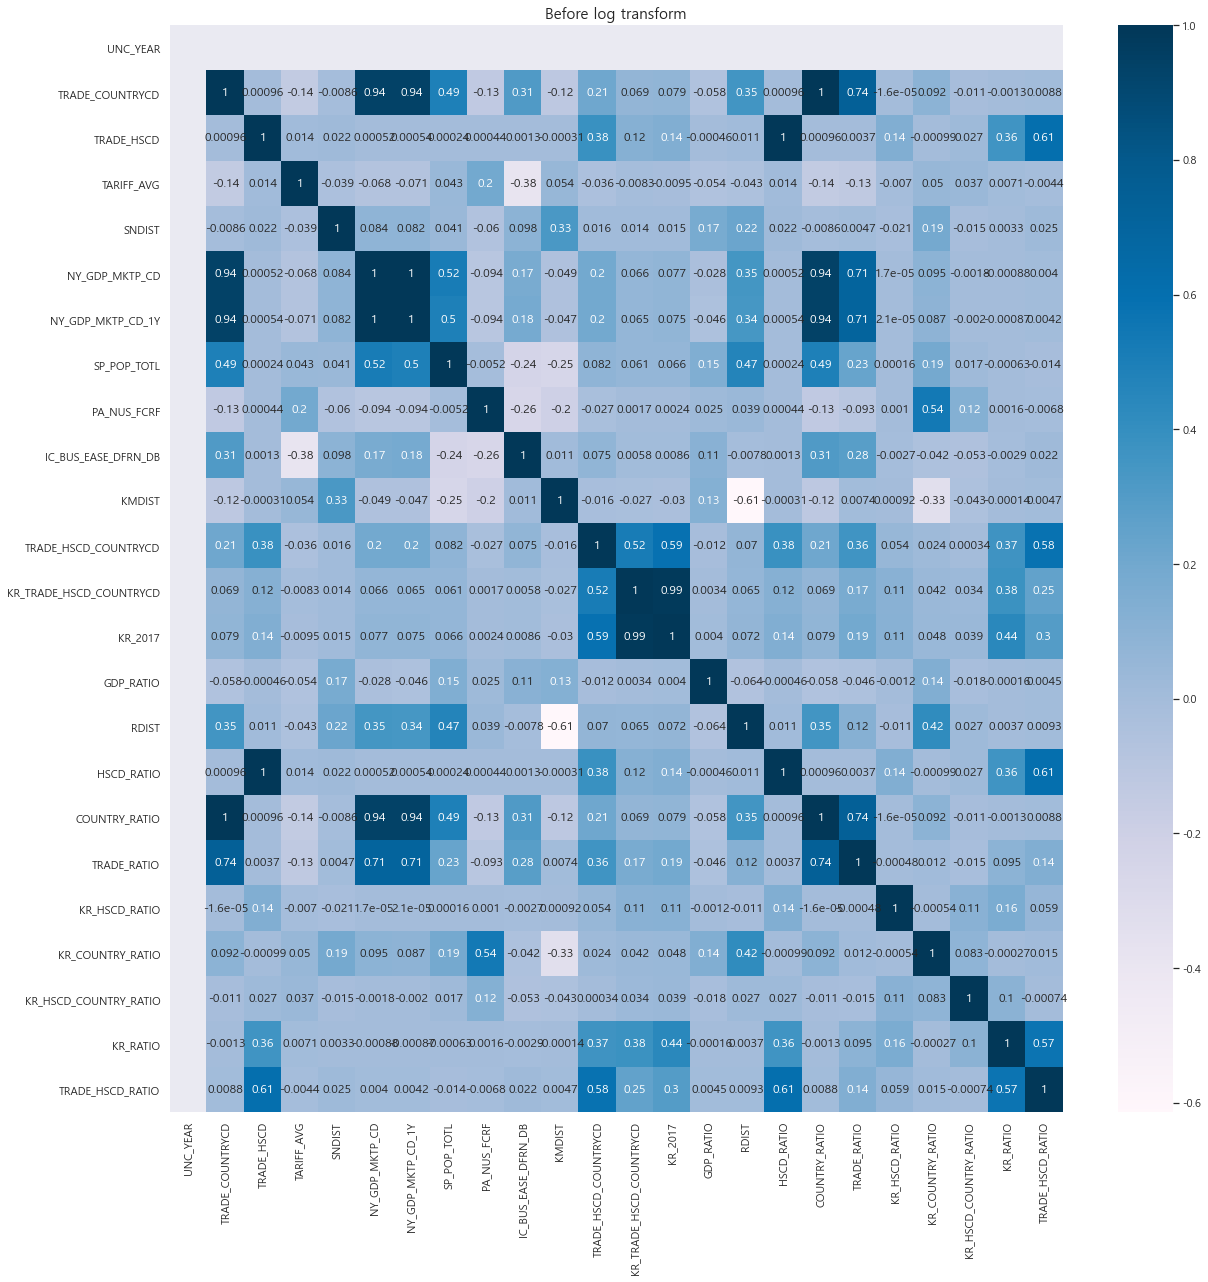

In [52]:
plt.figure(figsize = (20,20))
plt.title("Before log transform" , fontsize = 15)
sns.heatmap(numerical_data.corr(), annot = True , cmap="PuBu")
plt.savefig("corr1")

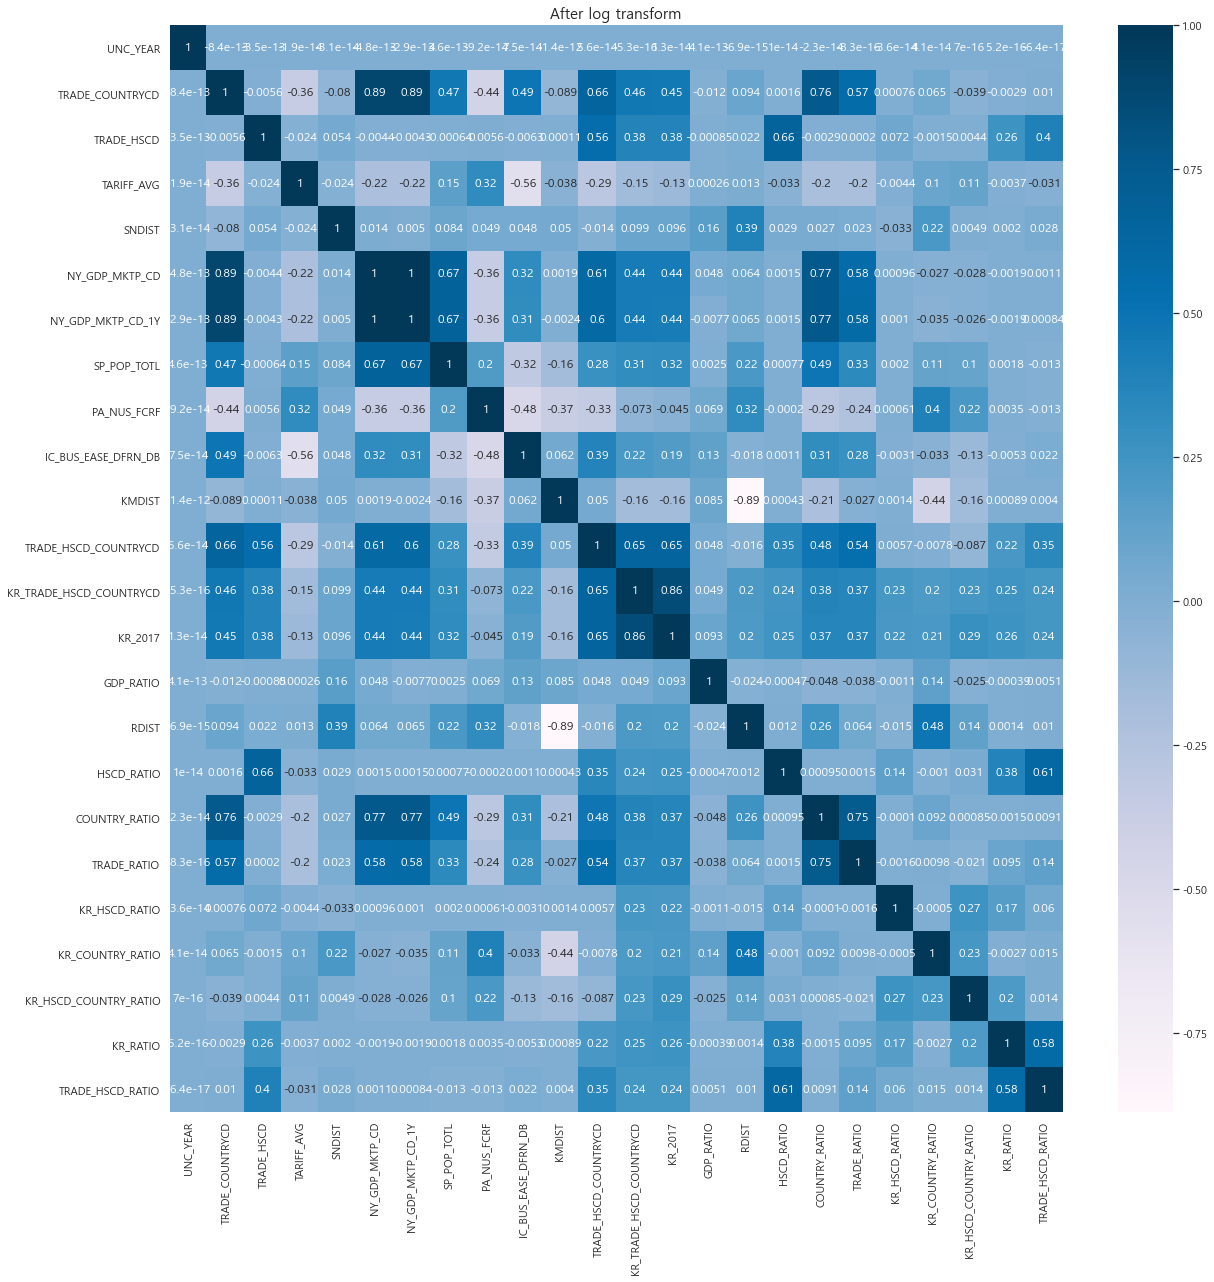

In [53]:
plt.figure(figsize = (20,20))
plt.title("After log transform" , fontsize = 15)
sns.heatmap(log_numerical_data.corr(), annot = True , cmap="PuBu")
plt.savefig("corr2")

##### skew 정도

In [54]:
print(numerical_data.skew())

UNC_YEAR                     0.000000
TRADE_COUNTRYCD              2.930884
TRADE_HSCD                   6.102355
TARIFF_AVG                  16.695286
SNDIST                       0.946453
NY_GDP_MKTP_CD               4.023612
NY_GDP_MKTP_CD_1Y            4.071015
SP_POP_TOTL                  3.897461
PA_NUS_FCRF                  4.077584
IC_BUS_EASE_DFRN_DB         -0.652442
KMDIST                       0.601956
TRADE_HSCD_COUNTRYCD        29.306004
KR_TRADE_HSCD_COUNTRYCD    112.976068
KR_2017                     96.779558
GDP_RATIO                   -2.080782
RDIST                        2.967152
HSCD_RATIO                   6.102355
COUNTRY_RATIO                2.930884
TRADE_RATIO                  4.909746
KR_HSCD_RATIO                3.459409
KR_COUNTRY_RATIO             2.882194
KR_HSCD_COUNTRY_RATIO       53.129099
KR_RATIO                    24.774182
TRADE_HSCD_RATIO            16.414531
dtype: float64


In [55]:
print(log_numerical_data.skew())

UNC_YEAR                    0.000000
TRADE_COUNTRYCD            -0.430451
TRADE_HSCD                  0.483129
TARIFF_AVG                  1.173207
SNDIST                      0.200431
NY_GDP_MKTP_CD              0.063832
NY_GDP_MKTP_CD_1Y           0.082418
SP_POP_TOTL                 0.419016
PA_NUS_FCRF                 1.383171
IC_BUS_EASE_DFRN_DB        -1.006900
KMDIST                     -1.168710
TRADE_HSCD_COUNTRYCD       -0.229137
KR_TRADE_HSCD_COUNTRYCD    -0.907868
KR_2017                    -0.917013
GDP_RATIO                  -2.527682
RDIST                       1.804880
HSCD_RATIO                  6.047608
COUNTRY_RATIO               2.817522
TRADE_RATIO                 4.360639
KR_HSCD_RATIO               3.038712
KR_COUNTRY_RATIO            2.745191
KR_HSCD_COUNTRY_RATIO      14.208158
KR_RATIO                   19.782674
TRADE_HSCD_RATIO           15.868225
dtype: float64


##### 수치형 변수 분포 

C:\Users\82104\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


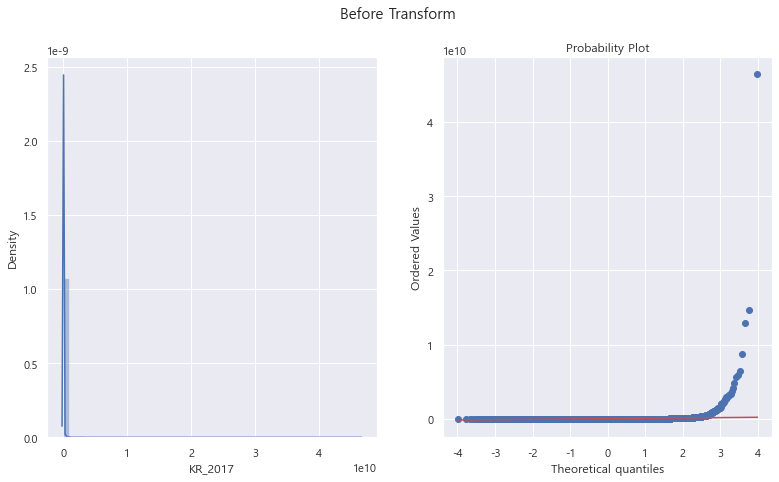

In [56]:
figure, axes = plt.subplots(ncols=2, nrows=1)
figure.set_size_inches(13,7)

sns.distplot(numerical_data["KR_2017"], ax=axes[0])
stats.probplot(numerical_data["KR_2017"], dist='norm', fit=True, plot=axes[1])
figure.suptitle("Before Transform" , fontsize = 15)
plt.savefig("KR_2017_1")

C:\Users\82104\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


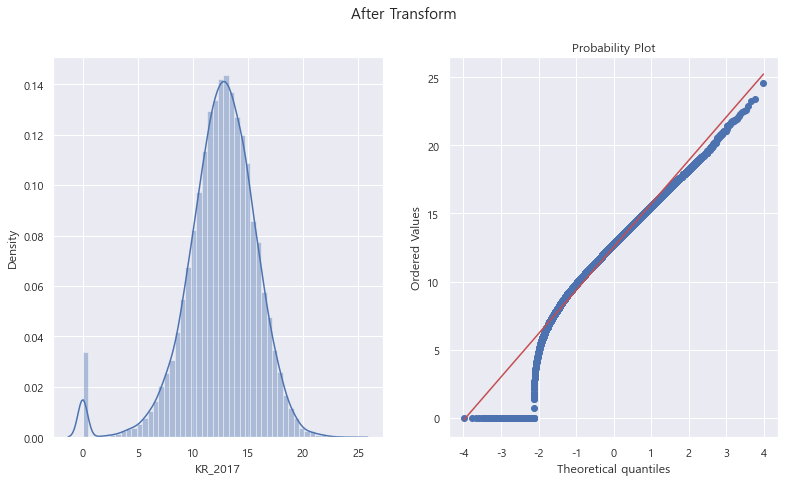

In [57]:
figure, axes = plt.subplots(ncols=2, nrows=1)
figure.set_size_inches(13,7)


sns.distplot(np.log1p(data["KR_2017"]), ax=axes[0])
stats.probplot(np.log1p(data["KR_2017"]), dist='norm', fit=True, plot=axes[1])
figure.suptitle("After Transform" , fontsize = 15)
plt.savefig("KR_2017_2")

C:\Users\82104\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


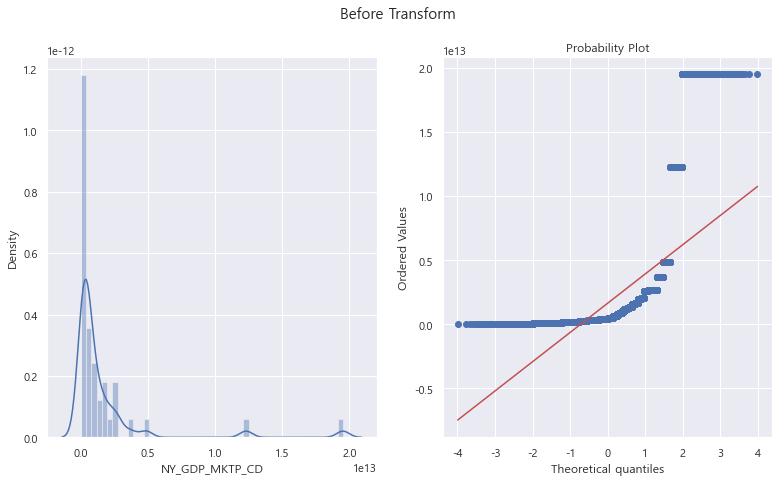

In [58]:
figure, axes = plt.subplots(ncols=2, nrows=1)
figure.set_size_inches(13,7)

sns.distplot(numerical_data["NY_GDP_MKTP_CD"], ax=axes[0])
stats.probplot(numerical_data["NY_GDP_MKTP_CD"], dist='norm', fit=True, plot=axes[1])
figure.suptitle("Before Transform" , fontsize = 15)
plt.savefig("NY_GDP_MKTP_CD_1")

C:\Users\82104\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


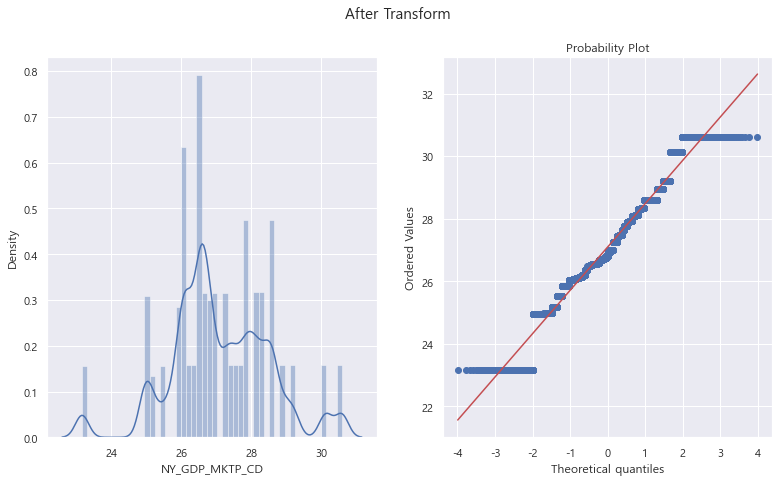

In [59]:
figure, axes = plt.subplots(ncols=2, nrows=1)
figure.set_size_inches(13,7)


sns.distplot(np.log1p(data["NY_GDP_MKTP_CD"]), ax=axes[0])
stats.probplot(np.log1p(data["NY_GDP_MKTP_CD"]), dist='norm', fit=True, plot=axes[1])
figure.suptitle("After Transform" , fontsize = 15)
plt.savefig("NY_GDP_MKTP_CD_2")

C:\Users\82104\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


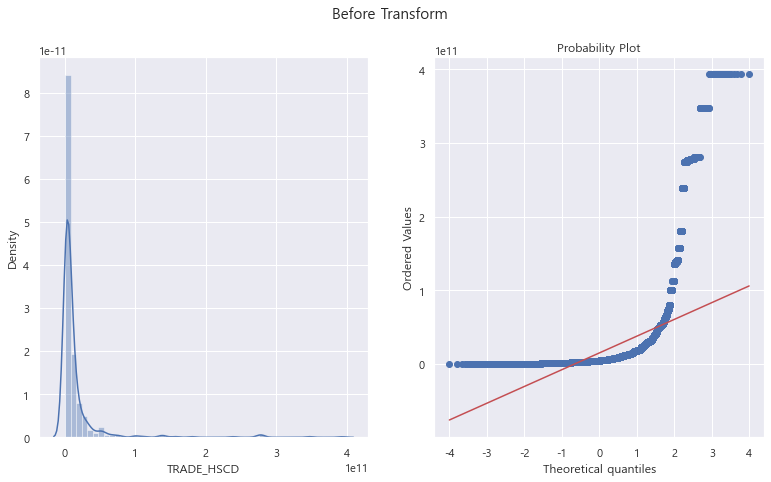

In [60]:
figure, axes = plt.subplots(ncols=2, nrows=1)
figure.set_size_inches(13,7)

sns.distplot(numerical_data["TRADE_HSCD"], ax=axes[0])
stats.probplot(numerical_data["TRADE_HSCD"], dist='norm', fit=True, plot=axes[1])
figure.suptitle("Before Transform" , fontsize = 15)
plt.savefig("TRADE_HSCD_1")


C:\Users\82104\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


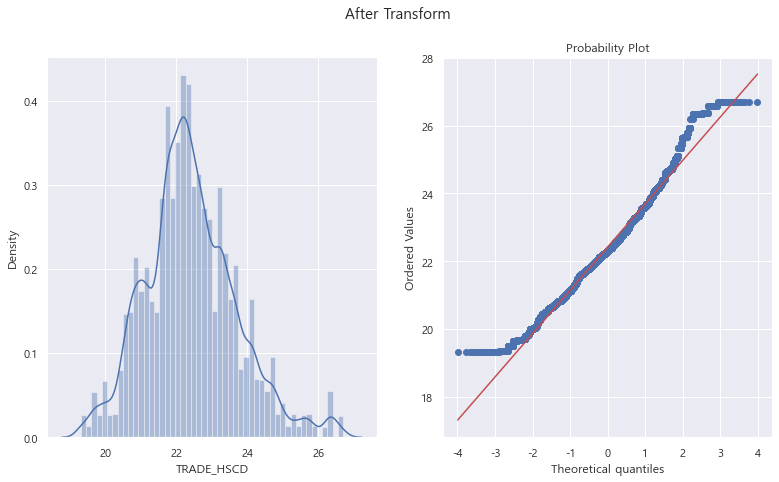

In [61]:
figure, axes = plt.subplots(ncols=2, nrows=1)
figure.set_size_inches(13,7)

sns.distplot(np.log1p(data["TRADE_HSCD"]), ax=axes[0])
stats.probplot(np.log1p(data["TRADE_HSCD"]), dist='norm', fit=True, plot=axes[1])
figure.suptitle("After Transform" , fontsize = 15)
plt.savefig("TRADE_HSCD_2")


##### 반응변수와의 산점도

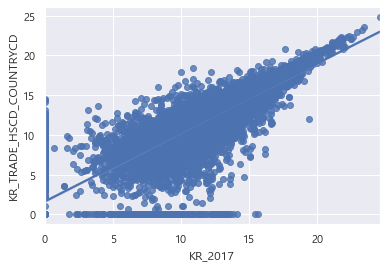

In [62]:
# KR_2017 vs KR_TRADE_HSCD_COUNTRYCD
sns.regplot(x="KR_2017" , y = "KR_TRADE_HSCD_COUNTRYCD",data=log_numerical_data)
plt.savefig("scatter_2")

<AxesSubplot:xlabel='TRADE_HSCD_COUNTRYCD', ylabel='KR_TRADE_HSCD_COUNTRYCD'>

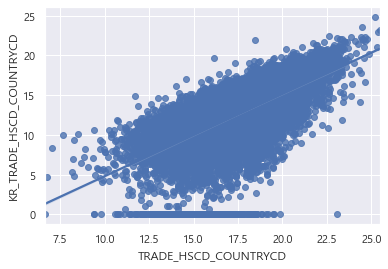

In [63]:
# TRADE_HSCD_COUNTRYCD vs KR_TRADE_HSCD_COUNTRYCD
sns.regplot(x="TRADE_HSCD_COUNTRYCD" , y = "KR_TRADE_HSCD_COUNTRYCD",data=log_numerical_data)

<AxesSubplot:xlabel='KMDIST', ylabel='KR_TRADE_HSCD_COUNTRYCD'>

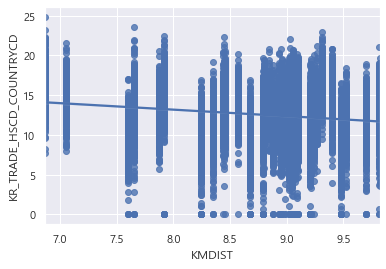

In [64]:
# KMDIST vs KR_TRADE_HSCD_COUNTRYCD
sns.regplot(x="KMDIST" , y = "KR_TRADE_HSCD_COUNTRYCD",data=log_numerical_data)

<AxesSubplot:xlabel='TRADE_HSCD', ylabel='KR_TRADE_HSCD_COUNTRYCD'>

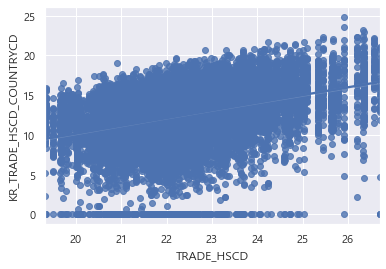

In [65]:
# TRADE_HSCD vs KR_TRADE_HSCD_COUNTRYCD
sns.regplot(x="TRADE_HSCD" , y = "KR_TRADE_HSCD_COUNTRYCD",data=log_numerical_data)

<AxesSubplot:xlabel='NY_GDP_MKTP_CD', ylabel='KR_TRADE_HSCD_COUNTRYCD'>

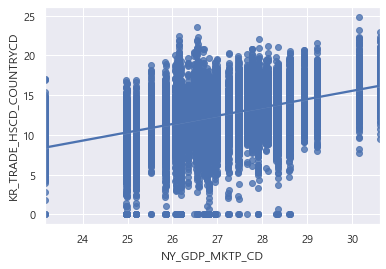

In [66]:
# NY_GDP_MKTP_CD vs KR_TRADE_HSCD_COUNTRYCD
sns.regplot(x="NY_GDP_MKTP_CD" , y = "KR_TRADE_HSCD_COUNTRYCD",data=log_numerical_data)

<AxesSubplot:xlabel='SP_POP_TOTL', ylabel='KR_TRADE_HSCD_COUNTRYCD'>

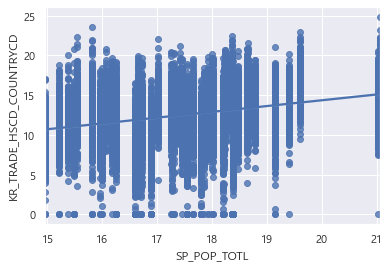

In [67]:
# SP_POP_TOTL vs KR_TRADE_HSCD_COUNTRYCD
sns.regplot(x="SP_POP_TOTL" , y = "KR_TRADE_HSCD_COUNTRYCD",data=log_numerical_data)

<AxesSubplot:xlabel='IC_BUS_EASE_DFRN_DB', ylabel='KR_TRADE_HSCD_COUNTRYCD'>

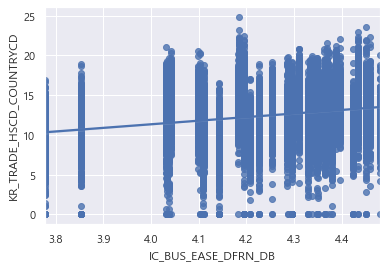

In [68]:
# IC_BUS_EASE_DFRN_DB vs KR_TRADE_HSCD_COUNTRYCD
sns.regplot(x="IC_BUS_EASE_DFRN_DB" , y = "KR_TRADE_HSCD_COUNTRYCD",data=log_numerical_data)

<AxesSubplot:xlabel='NY_GDP_MKTP_CD', ylabel='KR_TRADE_HSCD_COUNTRYCD'>

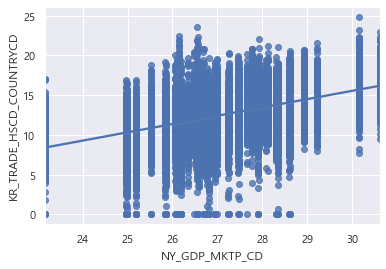

In [69]:
# NY_GDP_MKTP_CD vs KR_TRADE_HSCD_COUNTRYCD
sns.regplot(x="NY_GDP_MKTP_CD" , y = "KR_TRADE_HSCD_COUNTRYCD",data=log_numerical_data)

<AxesSubplot:xlabel='NY_GDP_MKTP_CD', ylabel='KR_TRADE_HSCD_COUNTRYCD'>

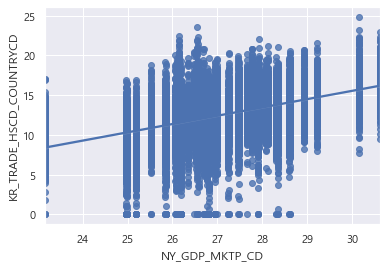

In [70]:
# NY_GDP_MKTP_CD vs KR_TRADE_HSCD_COUNTRYCD
sns.regplot(x="NY_GDP_MKTP_CD" , y = "KR_TRADE_HSCD_COUNTRYCD",data=log_numerical_data)

## STEP 5. 최종 모형 

### 각 seed 별 모형 검토 및 특성 중요도 산출

In [71]:
# 모형 구축을 위한 데이터 변환 
model_data=data.drop(['UNC_YEAR','COUNTRYCD'],axis=1)


model_cat=model_data[['dist','TARIFF','PA','BE']]
model_data=model_data.drop(['dist','TARIFF','PA','BE'],axis=1)

model_target=model_data['KR_TRADE_HSCD_COUNTRYCD']
model_data=model_data.drop('KR_TRADE_HSCD_COUNTRYCD',axis=1)

model_data2=pd.get_dummies(model_data,drop_first=True)
columns=model_data2.columns

model_num=model_data2.iloc[:,:22]
model_obj=model_data2.iloc[:,22:]


model_num=np.log1p(model_num)
model_target=np.log1p(model_target)

x=np.concatenate([model_num,model_obj,model_cat],axis=1)

d10=pd.DataFrame(x)
d10.columns=list(columns)+['dist','TARIFF','PA','BE']
d10['y']=model_target


mask=((d10['y']==0)&(d10['KR_2017']!=0))|((d10['y']!=0)&(d10['KR_2017']==0))
d100=d10[~mask]

model_f=d100
model_f=model_f.reset_index().drop('index',axis=1)

model_f=d100
model_f=model_f.reset_index().drop('index',axis=1)

y=model_f['y']
x=model_f.drop('y',axis=1)
x2=x.iloc[:,:22]

x3=x.iloc[:,22:]
name1=x2.columns
name2=x3.columns
ss=StandardScaler()
ss.fit(x2)
x_num=ss.transform(x2)
x=pd.DataFrame(x_num)
x=pd.concat([x,x3],axis=1)
x.columns=list(name1)+list(name2)

각 시드별 train_set 과 test_set의 score 점수를 저장하기 위한 리스트 선언 

In [72]:
train=[]
test=[]

### seed 41

In [73]:
#### 시드 41 ####
## 기존 변수의 설명력 ## 

model_f=d100
model_f=model_f.reset_index().drop('index',axis=1)
y=model_f['y']
x=model_f.drop('y',axis=1)
x=x[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST',
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
       'GDP_RATIO', 'RDIST', 'HSCD_RATIO', 'TRADE_RATIO',
       'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO', 'TRADE_HSCD_RATIO']]
name=x.columns
ss_f41=StandardScaler()
ss_f41.fit(x)
x=ss_f41.transform(x)
x=pd.DataFrame(x)
x.columns=list(name)
    
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=41)


final_xgbr_41=XGBRegressor(random_state=42)
final_xgbr_41.fit(x_train,y_train)

model_compare=d10[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST',
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
       'GDP_RATIO', 'RDIST', 'HSCD_RATIO', 'TRADE_RATIO',
       'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO', 'TRADE_HSCD_RATIO','y']]
y_c=model_compare['y']
x_c=model_compare.drop('y',axis=1)
x2_c=x_c[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST',
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
       'GDP_RATIO', 'RDIST', 'HSCD_RATIO', 'TRADE_RATIO',
       'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO', 'TRADE_HSCD_RATIO']]
name=x2_c.columns
x_num_c=ss_f41.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)
    
pred_41=final_xgbr_41.predict(x_c)
mae_41=mean_absolute_error(np.expm1(y_c),np.expm1(pred_41))
    
pred_all=final_xgbr_41.predict(x)
pred_test=final_xgbr_41.predict(x_test)
print("20768개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
print(final_xgbr_41.score(x_train,y_train))
print(final_xgbr_41.score(x_test,y_test))
print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_41)))

20768개 mae: 3657364.981047203
test mae: 5291741.839308816
0.9439275397888461
0.8370163399823769
21189개 mae: 3585888.5045754123


In [74]:
## 영향력 관측치 찾고 제거 후 모형 ##
for i in range(0,100):
    res_41=y_c-pred_41
    out_ind_41_1=res_41[(((res_41>5)|(res_41<-5)))].index
    out_ind_41_1=list(out_ind_41_1)
    
    model_f=d10
    model_f=model_f.drop(out_ind_41_1,axis=0)
    mask2=((model_f['y']==0)&(model_f['KR_2017']!=0))|((model_f['y']!=0)&(model_f['KR_2017']==0))
    model_f=model_f[~mask2]
    model_f=model_f.reset_index().drop('index',axis=1)
    y=model_f['y']
    x=model_f.drop('y',axis=1)
    x=x[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST',
           'NY_GDP_MKTP_CD','SP_POP_TOTL',
           'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
           'GDP_RATIO', 'RDIST', 'HSCD_RATIO', 'TRADE_RATIO',
           'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
           'KR_RATIO', 'TRADE_HSCD_RATIO']]
    name=x.columns
    ss_f41=StandardScaler()
    ss_f41.fit(x)
    x=ss_f41.transform(x)
    x=pd.DataFrame(x)
    x.columns=list(name)
        
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=41)
    
    
    final_xgbr_41=XGBRegressor(random_state=42)
    final_xgbr_41.fit(x_train,y_train)
    
    model_compare=d10[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST',
           'NY_GDP_MKTP_CD','SP_POP_TOTL',
           'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
           'GDP_RATIO', 'RDIST', 'HSCD_RATIO', 'TRADE_RATIO',
           'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
           'KR_RATIO', 'TRADE_HSCD_RATIO','y']]
    y_c=model_compare['y']
    x_c=model_compare.drop('y',axis=1)
    x2_c=x_c[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST',
           'NY_GDP_MKTP_CD','SP_POP_TOTL',
           'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
           'GDP_RATIO', 'RDIST', 'HSCD_RATIO', 'TRADE_RATIO',
           'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
           'KR_RATIO', 'TRADE_HSCD_RATIO']]
    name=x2_c.columns
    x_num_c=ss_f41.transform(x2_c)
    x_c=pd.DataFrame(x_num_c)
    x_c.columns=list(name)
        
    pred_41=final_xgbr_41.predict(x_c)
    mae_41=mean_absolute_error(np.expm1(y_c),np.expm1(pred_41))
        
    pred_all=final_xgbr_41.predict(x)
    pred_test=final_xgbr_41.predict(x_test)
    
    if mean_absolute_error(np.expm1(y_c),np.expm1(pred_41))<3450000:
        print(i,"번째 반복입니다.")
        print(x.shape[0],"개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
        print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
        print(final_xgbr_41.score(x_train,y_train))
        print(final_xgbr_41.score(x_test,y_test))
        print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_41)))
        break

8 번째 반복입니다.
20679 개 mae: 3496895.014653236
test mae: 4575543.8505000705
0.9455236908749131
0.8678821738243596
21189개 mae: 3423352.3290367466


In [75]:
## 최종 seed 41 모형 ##

model_f=d10
model_f=model_f.drop(out_ind_41_1,axis=0)
mask2=((model_f['y']==0)&(model_f['KR_2017']!=0))|((model_f['y']!=0)&(model_f['KR_2017']==0))
model_f=model_f[~mask2]
model_f=model_f.reset_index().drop('index',axis=1)
y=model_f['y']
x=model_f.drop('y',axis=1)
x=x[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST',
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
       'GDP_RATIO', 'RDIST', 'HSCD_RATIO', 'TRADE_RATIO',
       'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO', 'TRADE_HSCD_RATIO']]
name=x.columns
ss_f41=StandardScaler()
ss_f41.fit(x)
x=ss_f41.transform(x)
x=pd.DataFrame(x)
x.columns=list(name)
    
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=41)


final_xgbr_41=XGBRegressor(random_state=42)
final_xgbr_41.fit(x_train,y_train)

model_compare=d10[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST',
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
       'GDP_RATIO', 'RDIST', 'HSCD_RATIO', 'TRADE_RATIO',
       'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO', 'TRADE_HSCD_RATIO','y']]
y_c=model_compare['y']
x_c=model_compare.drop('y',axis=1)
x2_c=x_c[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST',
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
       'GDP_RATIO', 'RDIST', 'HSCD_RATIO', 'TRADE_RATIO',
       'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO', 'TRADE_HSCD_RATIO']]
name=x2_c.columns
x_num_c=ss_f41.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)
    
pred_41=final_xgbr_41.predict(x_c)
mae_41=mean_absolute_error(np.expm1(y_c),np.expm1(pred_41))
    
pred_all=final_xgbr_41.predict(x)
pred_test=final_xgbr_41.predict(x_test)
print(x.shape[0],"개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
print(final_xgbr_41.score(x_train,y_train))
print(final_xgbr_41.score(x_test,y_test))
print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_41)))
train.append(final_xgbr_41.score(x_train,y_train))
test.append(final_xgbr_41.score(x_test,y_test))

20679 개 mae: 3496895.014653236
test mae: 4575543.8505000705
0.9455236908749131
0.8678821738243596
21189개 mae: 3423352.3290367466


### seed 42

In [76]:
#### 시드 42 ####
## 변수 선택 후 기본 모형 ## 

model_f=d100
model_f=model_f.reset_index().drop('index',axis=1)
y=model_f['y']
x=model_f.drop('y',axis=1)
x=x[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST',
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
       'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
       'HSCD_RATIO', 
       'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO', 'TRADE_HSCD_RATIO']]
name=x.columns
ss_f42=StandardScaler()
ss_f42.fit(x)
x=ss_f42.transform(x)
x=pd.DataFrame(x)
x.columns=list(name)
    
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)


final_xgbr_42=XGBRegressor(random_state=42)
final_xgbr_42.fit(x_train,y_train)

model_compare=d10[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST',
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
       'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
       'HSCD_RATIO', 
       'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO', 'TRADE_HSCD_RATIO','y']]
y_c=model_compare['y']
x_c=model_compare.drop('y',axis=1)
x2_c=x_c[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST',
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
       'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
       'HSCD_RATIO', 
       'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO', 'TRADE_HSCD_RATIO']]
name=x2_c.columns
x_num_c=ss_f42.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)
    
pred_42=final_xgbr_42.predict(x_c)
mae_42=mean_absolute_error(np.expm1(y_c),np.expm1(pred_42))
    
pred_all=final_xgbr_42.predict(x)
pred_test=final_xgbr_42.predict(x_test)
print("20768개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
print(final_xgbr_42.score(x_train,y_train))
print(final_xgbr_42.score(x_test,y_test))
print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_42)))

20768개 mae: 3555162.1032237615
test mae: 6129085.119203719
0.9390726589227676
0.8458972582932602
21189개 mae: 3485824.0423936076


In [77]:
## 영향력 관측치 찾고 제거 후 모형 ##
for i in range(0,1000):
    res_42=y_c-pred_42
    out_ind_42=res_42[(((res_42>5)|(res_42<-5)))].index
    out_ind_42=list(out_ind_42)
    
    model_f=d10
    model_f=model_f.drop(out_ind_42,axis=0)
    mask2=((model_f['y']==0)&(model_f['KR_2017']!=0))|((model_f['y']!=0)&(model_f['KR_2017']==0))
    model_f=model_f[~mask2]
    
    model_f=model_f.reset_index().drop('index',axis=1)
    y=model_f['y']
    x=model_f.drop('y',axis=1)
    x=x[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST',
           'NY_GDP_MKTP_CD','SP_POP_TOTL',
           'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
           'HSCD_RATIO', 
           'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
           'KR_RATIO', 'TRADE_HSCD_RATIO']]
    name=x.columns
    ss_f42=StandardScaler()
    ss_f42.fit(x)
    x=ss_f42.transform(x)
    x=pd.DataFrame(x)
    x.columns=list(name)
        
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
    
    
    final_xgbr_42=XGBRegressor(random_state=42)
    final_xgbr_42.fit(x_train,y_train)
    
    model_compare=d10[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST',
           'NY_GDP_MKTP_CD','SP_POP_TOTL',
           'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
           'HSCD_RATIO', 
           'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
           'KR_RATIO', 'TRADE_HSCD_RATIO','y']]
    y_c=model_compare['y']
    x_c=model_compare.drop('y',axis=1)
    x2_c=x_c[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST',
           'NY_GDP_MKTP_CD','SP_POP_TOTL',
           'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
           'HSCD_RATIO', 
           'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
           'KR_RATIO', 'TRADE_HSCD_RATIO']]
    name=x2_c.columns
    x_num_c=ss_f42.transform(x2_c)
    x_c=pd.DataFrame(x_num_c)
    x_c.columns=list(name)
        
    pred_42=final_xgbr_42.predict(x_c)
    mae_42=mean_absolute_error(np.expm1(y_c),np.expm1(pred_42))
        
    pred_all=final_xgbr_42.predict(x)
    pred_test=final_xgbr_42.predict(x_test)
    
    if mean_absolute_error(np.expm1(y_c),np.expm1(pred_42))<3480000:
        print(i,"번째 반복입니다.")
        print(x.shape[0],"개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
        print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
        print(final_xgbr_42.score(x_train,y_train))
        print(final_xgbr_42.score(x_test,y_test))
        print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_42)))
        break;

39 번째 반복입니다.
20677 개 mae: 3439350.740708351
test mae: 4830291.74859936
0.9444410174499144
0.8680450559036714
21189개 mae: 3370768.90998877


In [78]:
## seed 42 최종 모형 ##

model_f=d10
model_f=model_f.drop(out_ind_42,axis=0)
mask2=((model_f['y']==0)&(model_f['KR_2017']!=0))|((model_f['y']!=0)&(model_f['KR_2017']==0))
model_f=model_f[~mask2]

model_f=model_f.reset_index().drop('index',axis=1)
y=model_f['y']
x=model_f.drop('y',axis=1)
x=x[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST',
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
       'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
       'HSCD_RATIO', 
       'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO', 'TRADE_HSCD_RATIO']]
name=x.columns
ss_f42=StandardScaler()
ss_f42.fit(x)
x=ss_f42.transform(x)
x=pd.DataFrame(x)
x.columns=list(name)
    
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)


final_xgbr_42=XGBRegressor(random_state=42)
final_xgbr_42.fit(x_train,y_train)

model_compare=d10[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST',
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
       'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
       'HSCD_RATIO', 
       'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO', 'TRADE_HSCD_RATIO','y']]
y_c=model_compare['y']
x_c=model_compare.drop('y',axis=1)
x2_c=x_c[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST',
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
       'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
       'HSCD_RATIO', 
       'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO', 'TRADE_HSCD_RATIO']]
name=x2_c.columns
x_num_c=ss_f42.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)
    
pred_42=final_xgbr_42.predict(x_c)
mae_42=mean_absolute_error(np.expm1(y_c),np.expm1(pred_42))
    
pred_all=final_xgbr_42.predict(x)
pred_test=final_xgbr_42.predict(x_test)
    
print(x.shape[0],"개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
print(final_xgbr_42.score(x_train,y_train))
print(final_xgbr_42.score(x_test,y_test))
print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_42)))
train.append(final_xgbr_42.score(x_train,y_train))
test.append(final_xgbr_42.score(x_test,y_test))

20677 개 mae: 3439350.740708351
test mae: 4830291.74859936
0.9444410174499144
0.8680450559036714
21189개 mae: 3370768.90998877


### seed 43

In [79]:
#### 시드 43 ####
## 기존 변수의 설명력 ## 

model_f=d100
model_f=model_f.reset_index().drop('index',axis=1)
y=model_f['y']
x=model_f.drop('y',axis=1)
x=x[['TRADE_COUNTRYCD',  
       
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
        'TRADE_RATIO',
       'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
       'TRADE_HSCD_RATIO']]
name=x.columns
ss_f43=StandardScaler()
ss_f43.fit(x)
x=ss_f43.transform(x)
x=pd.DataFrame(x)
x.columns=list(name)
    
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=43)


final_xgbr_43=XGBRegressor(random_state=42)
final_xgbr_43.fit(x_train,y_train)

model_compare=d10[['TRADE_COUNTRYCD',  
       
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
        'TRADE_RATIO',
       'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
       'TRADE_HSCD_RATIO','y']]
y_c=model_compare['y']
x_c=model_compare.drop('y',axis=1)
x2_c=x_c[['TRADE_COUNTRYCD',  
       
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
        'TRADE_RATIO',
       'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
       'TRADE_HSCD_RATIO']]
name=x2_c.columns
x_num_c=ss_f43.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)
    
pred_43=final_xgbr_43.predict(x_c)
mae_43=mean_absolute_error(np.expm1(y_c),np.expm1(pred_43))
    
pred_all=final_xgbr_43.predict(x)
pred_test=final_xgbr_43.predict(x_test)
print("20768개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
print(final_xgbr_43.score(x_train,y_train))
print(final_xgbr_43.score(x_test,y_test))
print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_43)))

20768개 mae: 3618553.9929523314
test mae: 4895778.053194298
0.933391436189772
0.8438773834964417
21189개 mae: 3548053.189289441


In [80]:
## 영향력 관측치 찾고 제거 후 모형 ##
for i in  range(0,1000):
    res_43=y_c-pred_43
    out_ind_43=res_43[(((res_43>5)|(res_43<-5)))].index
    out_ind_43=list(out_ind_43)
    
    model_f=d10
    model_f=model_f.drop(out_ind_43,axis=0)
    mask2=((model_f['y']==0)&(model_f['KR_2017']!=0))|((model_f['y']!=0)&(model_f['KR_2017']==0))
    
    model_f=model_f.reset_index().drop('index',axis=1)
    y=model_f['y']
    x=model_f.drop('y',axis=1)
    x=x[['TRADE_COUNTRYCD',  
           
           'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
            'TRADE_RATIO',
           'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
           'TRADE_HSCD_RATIO']]
    name=x.columns
    ss_f43=StandardScaler()
    ss_f43.fit(x)
    x=ss_f43.transform(x)
    x=pd.DataFrame(x)
    x.columns=list(name)
        
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=43)
    
    
    final_xgbr_43=XGBRegressor(random_state=42)
    final_xgbr_43.fit(x_train,y_train)
    
    model_compare=d10[['TRADE_COUNTRYCD',  
           
           'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
            'TRADE_RATIO',
           'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
           'TRADE_HSCD_RATIO','y']]
    y_c=model_compare['y']
    x_c=model_compare.drop('y',axis=1)
    x2_c=x_c[['TRADE_COUNTRYCD',  
           
           'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
            'TRADE_RATIO',
           'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
           'TRADE_HSCD_RATIO']]
    name=x2_c.columns
    x_num_c=ss_f43.transform(x2_c)
    x_c=pd.DataFrame(x_num_c)
    x_c.columns=list(name)
        
    pred_43=final_xgbr_43.predict(x_c)
    mae_43=mean_absolute_error(np.expm1(y_c),np.expm1(pred_43))
        
    pred_all=final_xgbr_43.predict(x)
    pred_test=final_xgbr_43.predict(x_test)
    if mean_absolute_error(np.expm1(y_c),np.expm1(pred_43))<3210000:
        print(i,"번째 반복입니다.")
        print(x.shape[0],"개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
        print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
        print(final_xgbr_43.score(x_train,y_train))
        print(final_xgbr_43.score(x_test,y_test))
        print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_43)))
        break

65 번째 반복입니다.
20834 개 mae: 3242216.6842958485
test mae: 3154023.4862205144
0.9385469952967369
0.8494979505936442
21189개 mae: 3208387.242906975


In [81]:
## 시드 43 최종 모형 ##

model_f=d10
model_f=model_f.drop(out_ind_43,axis=0)
mask2=((model_f['y']==0)&(model_f['KR_2017']!=0))|((model_f['y']!=0)&(model_f['KR_2017']==0))

model_f=model_f.reset_index().drop('index',axis=1)
y=model_f['y']
x=model_f.drop('y',axis=1)
x=x[['TRADE_COUNTRYCD',  
       
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
        'TRADE_RATIO',
       'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
       'TRADE_HSCD_RATIO']]
name=x.columns
ss_f44=StandardScaler()
ss_f44.fit(x)
x=ss_f44.transform(x)
x=pd.DataFrame(x)
x.columns=list(name)
    
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=43)


final_xgbr_43=XGBRegressor(random_state=42)
final_xgbr_43.fit(x_train,y_train)

model_compare=d10[['TRADE_COUNTRYCD',  
       
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
        'TRADE_RATIO',
       'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
       'TRADE_HSCD_RATIO','y']]
y_c=model_compare['y']
x_c=model_compare.drop('y',axis=1)
x2_c=x_c[['TRADE_COUNTRYCD',  
       
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
        'TRADE_RATIO',
       'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
       'TRADE_HSCD_RATIO']]
name=x2_c.columns
x_num_c=ss_f43.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)
    
pred_43=final_xgbr_43.predict(x_c)
mae_43=mean_absolute_error(np.expm1(y_c),np.expm1(pred_43))
    
pred_all=final_xgbr_43.predict(x)
pred_test=final_xgbr_43.predict(x_test)

print(x.shape[0],"개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
print(final_xgbr_43.score(x_train,y_train))
print(final_xgbr_43.score(x_test,y_test))
print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_43)))
train.append(final_xgbr_43.score(x_train,y_train))
test.append(final_xgbr_43.score(x_test,y_test))

20834 개 mae: 3242216.6842958485
test mae: 3154023.4862205144
0.9385469952967369
0.8494979505936442
21189개 mae: 3208387.242906975


### seed 44

In [82]:
#### 시드 44 ####
## 기존 변수의 설명력 ## 

model_f=d100
model_f=model_f.reset_index().drop('index',axis=1)
y=model_f['y']
x=model_f.drop('y',axis=1)
x=x[['TRADE_COUNTRYCD',  
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
        'KMDIST', 
        'HSCD_RATIO', 
       'KR_HSCD_RATIO', 
       'KR_RATIO', 'TRADE_HSCD_RATIO']]
name=x.columns
ss_f44=StandardScaler()
ss_f44.fit(x)
x=ss_f44.transform(x)
x=pd.DataFrame(x)
x.columns=list(name)
    
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=44)


final_xgbr_44=XGBRegressor(random_state=42)
final_xgbr_44.fit(x_train,y_train)

model_compare=d10[['TRADE_COUNTRYCD',  
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
        'KMDIST', 
        'HSCD_RATIO', 
       'KR_HSCD_RATIO', 
       'KR_RATIO', 'TRADE_HSCD_RATIO','y']]
y_c=model_compare['y']
x_c=model_compare.drop('y',axis=1)
x2_c=x_c[['TRADE_COUNTRYCD',  
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
        'KMDIST', 
        'HSCD_RATIO', 
       'KR_HSCD_RATIO', 
       'KR_RATIO', 'TRADE_HSCD_RATIO']]
name=x2_c.columns
x_num_c=ss_f44.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)
    
pred_44=final_xgbr_44.predict(x_c)
mae_44=mean_absolute_error(np.expm1(y_c),np.expm1(pred_44))
    
pred_all=final_xgbr_44.predict(x)
pred_test=final_xgbr_44.predict(x_test)
print("20768개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
print(final_xgbr_44.score(x_train,y_train))
print(final_xgbr_44.score(x_test,y_test))
print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_44)))

20768개 mae: 4604404.479104594
test mae: 9083929.7504485
0.9299663501310813
0.8425618300745293
21189개 mae: 4513994.918326001


In [83]:
## 영향력 관측치 찾고 제거 후 모형 ##
for i in range(0,100):
    res_44=y_c-pred_44
    out_ind_44=res_44[(((res_44>5)|(res_44<-5)))].index
    out_ind_44=list(out_ind_44)
    model_f=d10
    model_f=model_f.drop(out_ind_44,axis=0)
    mask2=((model_f['y']==0)&(model_f['KR_2017']!=0))|((model_f['y']!=0)&(model_f['KR_2017']==0))
    model_f=model_f[~mask2]
    model_f=model_f.reset_index().drop('index',axis=1)
    y=model_f['y']
    x=model_f.drop('y',axis=1)

    x=x[['TRADE_COUNTRYCD',  
         'NY_GDP_MKTP_CD','SP_POP_TOTL',
         'KMDIST', 
         'HSCD_RATIO', 
         'KR_HSCD_RATIO', 
         'KR_RATIO', 'TRADE_HSCD_RATIO']]
    name=x.columns
    ss_f44=StandardScaler()
    ss_f44.fit(x)
    x=ss_f44.transform(x)
    x=pd.DataFrame(x)
    x.columns=list(name)
    
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=44)


    final_xgbr_44=XGBRegressor(random_state=42)
    final_xgbr_44.fit(x_train,y_train)

    model_compare=d10[['TRADE_COUNTRYCD',  
                       'NY_GDP_MKTP_CD','SP_POP_TOTL',
                       'KMDIST', 
                       'HSCD_RATIO', 
                       'KR_HSCD_RATIO', 
                       'KR_RATIO', 'TRADE_HSCD_RATIO','y']]
    y_c=model_compare['y']
    x_c=model_compare.drop('y',axis=1)
    x2_c=x_c[['TRADE_COUNTRYCD',  
              'NY_GDP_MKTP_CD','SP_POP_TOTL',
              'KMDIST', 
              'HSCD_RATIO', 
              'KR_HSCD_RATIO', 
              'KR_RATIO', 'TRADE_HSCD_RATIO']]
    name=x2_c.columns
    x_num_c=ss_f44.transform(x2_c)
    x_c=pd.DataFrame(x_num_c)
    x_c.columns=list(name)
    
    pred_44=final_xgbr_44.predict(x_c)
    mae_44=mean_absolute_error(np.expm1(y_c),np.expm1(pred_44))
    
    pred_all=final_xgbr_44.predict(x)
    pred_test=final_xgbr_44.predict(x_test)
    
    if mean_absolute_error(np.expm1(y_c),np.expm1(pred_44))<3500000:
        print(i,"번째 반복입니다.")
        print(x.shape[0],"개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
        print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
        print(final_xgbr_44.score(x_train,y_train))
        print(final_xgbr_44.score(x_test,y_test))
        print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_44)))
        break


29 번째 반복입니다.
20665 개 mae: 3468414.5997446063
test mae: 4490688.422846914
0.9396394857673974
0.8628087387661735
21189개 mae: 3401344.939065811


In [84]:
## 최종 seed 44 모형 ##
out_ind_44
model_f=d10
model_f=model_f.drop(out_ind_44,axis=0)
mask2=((model_f['y']==0)&(model_f['KR_2017']!=0))|((model_f['y']!=0)&(model_f['KR_2017']==0))
model_f=model_f[~mask2]
model_f=model_f.reset_index().drop('index',axis=1)
y=model_f['y']
x=model_f.drop('y',axis=1)

x=x[['TRADE_COUNTRYCD',  
     'NY_GDP_MKTP_CD','SP_POP_TOTL',
     'KMDIST', 
     'HSCD_RATIO', 
     'KR_HSCD_RATIO', 
     'KR_RATIO', 'TRADE_HSCD_RATIO']]
name=x.columns
ss_f44=StandardScaler()
ss_f44.fit(x)
x=ss_f44.transform(x)
x=pd.DataFrame(x)
x.columns=list(name)

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=44)


final_xgbr_44=XGBRegressor(random_state=42)
final_xgbr_44.fit(x_train,y_train)

model_compare=d10[['TRADE_COUNTRYCD',  
                   'NY_GDP_MKTP_CD','SP_POP_TOTL',
                   'KMDIST', 
                   'HSCD_RATIO', 
                   'KR_HSCD_RATIO', 
                   'KR_RATIO', 'TRADE_HSCD_RATIO','y']]
y_c=model_compare['y']
x_c=model_compare.drop('y',axis=1)
x2_c=x_c[['TRADE_COUNTRYCD',  
          'NY_GDP_MKTP_CD','SP_POP_TOTL',
          'KMDIST', 
          'HSCD_RATIO', 
          'KR_HSCD_RATIO', 
          'KR_RATIO', 'TRADE_HSCD_RATIO']]
name=x2_c.columns
x_num_c=ss_f44.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)

pred_44=final_xgbr_44.predict(x_c)
mae_44=mean_absolute_error(np.expm1(y_c),np.expm1(pred_44))

pred_all=final_xgbr_44.predict(x)
pred_test=final_xgbr_44.predict(x_test)
print(x.shape[0],"개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
print(final_xgbr_44.score(x_train,y_train))
print(final_xgbr_44.score(x_test,y_test))
print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_44)))
train.append(final_xgbr_44.score(x_train,y_train))
test.append(final_xgbr_44.score(x_test,y_test))

20665 개 mae: 3468414.5997446063
test mae: 4490688.422846914
0.9396394857673974
0.8628087387661735
21189개 mae: 3401344.939065811


### seed 45

In [85]:
#### 시드 45 ####
## 기존 변수의 설명력 ## 

model_f=d100
model_f=model_f.reset_index().drop('index',axis=1)
y=model_f['y']
x=model_f.drop('y',axis=1)
x=x[['TRADE_COUNTRYCD',  
       'NY_GDP_MKTP_CD',
       'KMDIST', 
        
       'KR_HSCD_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO', 'TRADE_HSCD_RATIO']]
name=x.columns
ss_f45=StandardScaler()
ss_f45.fit(x)
x=ss_f45.transform(x)
x=pd.DataFrame(x)
x.columns=list(name)
    
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=45)


final_xgbr_45=XGBRegressor(random_state=42)
final_xgbr_45.fit(x_train,y_train)

model_compare=d10[['TRADE_COUNTRYCD',  
       'NY_GDP_MKTP_CD',
       'KMDIST', 
        
       'KR_HSCD_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO', 'TRADE_HSCD_RATIO','y']]
y_c=model_compare['y']
x_c=model_compare.drop('y',axis=1)
x2_c=x_c[['TRADE_COUNTRYCD',  
       'NY_GDP_MKTP_CD',
       'KMDIST', 
        
       'KR_HSCD_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO', 'TRADE_HSCD_RATIO']]
name=x2_c.columns
x_num_c=ss_f45.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)
    
pred_45=final_xgbr_45.predict(x_c)
mae_45=mean_absolute_error(np.expm1(y_c),np.expm1(pred_45))
    
pred_all=final_xgbr_45.predict(x)
pred_test=final_xgbr_45.predict(x_test)
print("20768개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
print(final_xgbr_45.score(x_train,y_train))
print(final_xgbr_45.score(x_test,y_test))
print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_45)))


20768개 mae: 3650721.489678352
test mae: 6013235.752589103
0.9257349134025434
0.8405056445278791
21189개 mae: 3579500.828952099


In [86]:
## 영향력 관측치 찾고 제거 후 모형 ##
for i in range(0,1000):
    res_45=y_c-pred_45
    out_ind_45=res_45[(((res_45>5)|(res_45<-5)))].index
    out_ind_45=list(out_ind_45)
    model_f=d10
    model_f=model_f.drop(out_ind_45,axis=0)
    mask2=((model_f['y']==0)&(model_f['KR_2017']!=0))|((model_f['y']!=0)&(model_f['KR_2017']==0))
    model_f=model_f[~mask2]
    
    model_f=model_f.reset_index().drop('index',axis=1)
    y=model_f['y']
    x=model_f.drop('y',axis=1)
    x=x[['TRADE_COUNTRYCD',  
           'NY_GDP_MKTP_CD',
           'KMDIST', 
            
           'KR_HSCD_RATIO', 'KR_HSCD_COUNTRY_RATIO',
           'KR_RATIO', 'TRADE_HSCD_RATIO']]
    name=x.columns
    ss_f45=StandardScaler()
    ss_f45.fit(x)
    x=ss_f45.transform(x)
    x=pd.DataFrame(x)
    x.columns=list(name)
        
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=45)
    
    
    final_xgbr_45=XGBRegressor(random_state=42)
    final_xgbr_45.fit(x_train,y_train)
    
    model_compare=d10[['TRADE_COUNTRYCD',  
           'NY_GDP_MKTP_CD',
           'KMDIST', 
            
           'KR_HSCD_RATIO', 'KR_HSCD_COUNTRY_RATIO',
           'KR_RATIO', 'TRADE_HSCD_RATIO','y']]
    y_c=model_compare['y']
    x_c=model_compare.drop('y',axis=1)
    x2_c=x_c[['TRADE_COUNTRYCD',  
           'NY_GDP_MKTP_CD',
           'KMDIST', 
            
           'KR_HSCD_RATIO', 'KR_HSCD_COUNTRY_RATIO',
           'KR_RATIO', 'TRADE_HSCD_RATIO']]
    name=x2_c.columns
    x_num_c=ss_f45.transform(x2_c)
    x_c=pd.DataFrame(x_num_c)
    x_c.columns=list(name)
        
    pred_45=final_xgbr_45.predict(x_c)
    mae_45=mean_absolute_error(np.expm1(y_c),np.expm1(pred_45))
        
    pred_all=final_xgbr_45.predict(x)
    pred_test=final_xgbr_45.predict(x_test)
    if mean_absolute_error(np.expm1(y_c),np.expm1(pred_45))<3370000:
        print(i,"번째 반복입니다.")
        print(x.shape[0],"개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
        print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
        print(final_xgbr_45.score(x_train,y_train))
        print(final_xgbr_45.score(x_test,y_test))
        print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_45)))
        break

129 번째 반복입니다.
20660 개 mae: 3333903.2400442422
test mae: 3476222.466029211
0.935795013036074
0.8623869373390218
21189개 mae: 3272420.171715179


In [87]:
##  Seed 45 최종 모형 ##
model_f=d10
model_f=model_f.drop(out_ind_45,axis=0)
mask2=((model_f['y']==0)&(model_f['KR_2017']!=0))|((model_f['y']!=0)&(model_f['KR_2017']==0))
model_f=model_f[~mask2]

model_f=model_f.reset_index().drop('index',axis=1)
y=model_f['y']
x=model_f.drop('y',axis=1)
x=x[['TRADE_COUNTRYCD',  
       'NY_GDP_MKTP_CD',
       'KMDIST', 
        
       'KR_HSCD_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO', 'TRADE_HSCD_RATIO']]
name=x.columns
ss_f45=StandardScaler()
ss_f45.fit(x)
x=ss_f45.transform(x)
x=pd.DataFrame(x)
x.columns=list(name)
    
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=45)


final_xgbr_45=XGBRegressor(random_state=42)
final_xgbr_45.fit(x_train,y_train)

model_compare=d10[['TRADE_COUNTRYCD',  
       'NY_GDP_MKTP_CD',
       'KMDIST', 
        
       'KR_HSCD_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO', 'TRADE_HSCD_RATIO','y']]
y_c=model_compare['y']
x_c=model_compare.drop('y',axis=1)
x2_c=x_c[['TRADE_COUNTRYCD',  
       'NY_GDP_MKTP_CD',
       'KMDIST', 
        
       'KR_HSCD_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO', 'TRADE_HSCD_RATIO']]
name=x2_c.columns
x_num_c=ss_f45.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)
    
pred_45=final_xgbr_45.predict(x_c)
mae_45=mean_absolute_error(np.expm1(y_c),np.expm1(pred_45))
    
pred_all=final_xgbr_45.predict(x)
pred_test=final_xgbr_45.predict(x_test)

print(x.shape[0],"개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
print(final_xgbr_45.score(x_train,y_train))
print(final_xgbr_45.score(x_test,y_test))
print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_45)))
train.append(final_xgbr_45.score(x_train,y_train))
test.append(final_xgbr_45.score(x_test,y_test))

20660 개 mae: 3333903.2400442422
test mae: 3476222.466029211
0.935795013036074
0.8623869373390218
21189개 mae: 3272420.171715179


### seed 46

In [88]:
#### 시드 46 ####
## 기존 변수의 설명력 ## 

model_f=d100
model_f=model_f.reset_index().drop('index',axis=1)
y=model_f['y']
x=model_f.drop('y',axis=1)
x=x[['SNDIST',
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
        'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
        'HSCD_RATIO', 
       'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO']]
name=x.columns
ss_f46=StandardScaler()
ss_f46.fit(x)
x=ss_f46.transform(x)
x=pd.DataFrame(x)
x.columns=list(name)
    
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=46)


final_xgbr_46=XGBRegressor(random_state=42)
final_xgbr_46.fit(x_train,y_train)

model_compare=d10[['SNDIST',
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
        'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
        'HSCD_RATIO', 
       'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO','y']]
y_c=model_compare['y']
x_c=model_compare.drop('y',axis=1)
x2_c=x_c[['SNDIST',
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
        'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
        'HSCD_RATIO', 
       'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO']]
name=x2_c.columns
x_num_c=ss_f46.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)
    
pred_46=final_xgbr_46.predict(x_c)
mae_46=mean_absolute_error(np.expm1(y_c),np.expm1(pred_46))
    
pred_all=final_xgbr_46.predict(x)
pred_test=final_xgbr_46.predict(x_test)
print("20768개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
print(final_xgbr_46.score(x_train,y_train))
print(final_xgbr_46.score(x_test,y_test))
print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_46)))
train.append(final_xgbr_46.score(x_train,y_train))
test.append(final_xgbr_46.score(x_test,y_test))


20768개 mae: 3262962.9939109823
test mae: 4090874.018993443
0.9354989653158478
0.833364204749298
21189개 mae: 3199356.371842055


모형 잔차를 통해 영향력 관측치들을 찾고 제거를 해보았지만, 

모델 성능이 좋아지지 않아, 기본 성능을 사용함.

### seed 47

In [89]:
#### 시드 47 ####
## 기존 변수의 설명력 ## 

model_f=d100
model_f=model_f.reset_index().drop('index',axis=1)
y=model_f['y']
x=model_f.drop('y',axis=1)
x=x[[ 'TRADE_HSCD',  
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
       'GDP_RATIO', 'RDIST', 
       'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO']]
name=x.columns
ss_f47=StandardScaler()
ss_f47.fit(x)
x=ss_f47.transform(x)
x=pd.DataFrame(x)
x.columns=list(name)
    
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=47)


final_xgbr_47=XGBRegressor(random_state=42)
final_xgbr_47.fit(x_train,y_train)

model_compare=d10[[ 'TRADE_HSCD',  
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
       'GDP_RATIO', 'RDIST', 
       'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO','y']]
y_c=model_compare['y']
x_c=model_compare.drop('y',axis=1)
x2_c=x_c[[ 'TRADE_HSCD',  
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
       'GDP_RATIO', 'RDIST', 
       'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO']]
name=x2_c.columns
x_num_c=ss_f47.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)
    
pred_47=final_xgbr_47.predict(x_c)
mae_47=mean_absolute_error(np.expm1(y_c),np.expm1(pred_47))
    
pred_all=final_xgbr_47.predict(x)
pred_test=final_xgbr_47.predict(x_test)
print("20768개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
print(final_xgbr_47.score(x_train,y_train))
print(final_xgbr_47.score(x_test,y_test))
print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_47)))


20768개 mae: 3480639.8559453213
test mae: 4567877.8366674455
0.9414068966007859
0.8236802751836386
21189개 mae: 3412796.982830562


In [90]:
## 영향력 관측치 찾고 제거 후 모형 ##
for i in range(0,1000):
    res_47=y_c-pred_47
    out_ind_47=res_47[(((res_47>5)|(res_47<-5)))].index
    out_ind_47=list(out_ind_47)
    model_f=d10
    model_f=model_f.drop(out_ind_47,axis=0)
    mask2=((model_f['y']==0)&(model_f['KR_2017']!=0))|((model_f['y']!=0)&(model_f['KR_2017']==0))
    model_f=model_f[~mask2]
    model_f=model_f.reset_index().drop('index',axis=1)
    y=model_f['y']
    x=model_f.drop('y',axis=1)
    x=x[[ 'TRADE_HSCD',  
           'NY_GDP_MKTP_CD','SP_POP_TOTL',
           'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
           'GDP_RATIO', 'RDIST', 
           'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
           'KR_RATIO']]
    name=x.columns
    ss_f47=StandardScaler()
    ss_f47.fit(x)
    x=ss_f47.transform(x)
    x=pd.DataFrame(x)
    x.columns=list(name)
        
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=47)
    
    
    final_xgbr_47=XGBRegressor(random_state=42)
    final_xgbr_47.fit(x_train,y_train)
    
    model_compare=d10[[ 'TRADE_HSCD',  
           'NY_GDP_MKTP_CD','SP_POP_TOTL',
           'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
           'GDP_RATIO', 'RDIST', 
           'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
           'KR_RATIO','y']]
    y_c=model_compare['y']
    x_c=model_compare.drop('y',axis=1)
    x2_c=x_c[[ 'TRADE_HSCD',  
           'NY_GDP_MKTP_CD','SP_POP_TOTL',
           'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
           'GDP_RATIO', 'RDIST', 
           'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
           'KR_RATIO']]
    name=x2_c.columns
    x_num_c=ss_f47.transform(x2_c)
    x_c=pd.DataFrame(x_num_c)
    x_c.columns=list(name)
        
    pred_47=final_xgbr_47.predict(x_c)
    mae_47=mean_absolute_error(np.expm1(y_c),np.expm1(pred_47))
        
    pred_all=final_xgbr_47.predict(x)
    pred_test=final_xgbr_47.predict(x_test)
    if mean_absolute_error(np.expm1(y_c),np.expm1(pred_47))<3300000:
        print(i,"번째 반복입니다.")
        print(x.shape[0],"개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
        print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
        print(final_xgbr_47.score(x_train,y_train))
        print(final_xgbr_47.score(x_test,y_test))
        print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_47)))
        break

44 번째 반복입니다.
20662 개 mae: 3336955.6729436647
test mae: 3592752.577485271
0.945280020510802
0.860447394645016
21189개 mae: 3268840.9593852786


In [91]:
## seed 47 최적 모형 ##

model_f=d10
model_f=model_f.drop(out_ind_47,axis=0)
mask2=((model_f['y']==0)&(model_f['KR_2017']!=0))|((model_f['y']!=0)&(model_f['KR_2017']==0))
model_f=model_f[~mask2]
model_f=model_f.reset_index().drop('index',axis=1)
y=model_f['y']
x=model_f.drop('y',axis=1)
x=x[[ 'TRADE_HSCD',  
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
       'GDP_RATIO', 'RDIST', 
       'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO']]
name=x.columns
ss_f47=StandardScaler()
ss_f47.fit(x)
x=ss_f47.transform(x)
x=pd.DataFrame(x)
x.columns=list(name)
    
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=47)


final_xgbr_47=XGBRegressor(random_state=42)
final_xgbr_47.fit(x_train,y_train)

model_compare=d10[[ 'TRADE_HSCD',  
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
       'GDP_RATIO', 'RDIST', 
       'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO','y']]
y_c=model_compare['y']
x_c=model_compare.drop('y',axis=1)
x2_c=x_c[[ 'TRADE_HSCD',  
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
       'GDP_RATIO', 'RDIST', 
       'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO']]
name=x2_c.columns
x_num_c=ss_f47.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)
    
pred_47=final_xgbr_47.predict(x_c)
mae_47=mean_absolute_error(np.expm1(y_c),np.expm1(pred_47))
    
pred_all=final_xgbr_47.predict(x)
pred_test=final_xgbr_47.predict(x_test)

print(x.shape[0],"개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
print(final_xgbr_47.score(x_train,y_train))
print(final_xgbr_47.score(x_test,y_test))
print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_47)))
train.append(final_xgbr_47.score(x_train,y_train))
test.append(final_xgbr_47.score(x_test,y_test))

20662 개 mae: 3336955.6729436647
test mae: 3592752.577485271
0.945280020510802
0.860447394645016
21189개 mae: 3268840.9593852786


### seed 48

In [92]:
#### 시드 48 ####
## 기존 변수의 설명력 ## 

model_f=d100
model_f=model_f.reset_index().drop('index',axis=1)
y=model_f['y']
x=model_f.drop('y',axis=1)
x=x[[ 
       'NY_GDP_MKTP_CD',
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
       
       'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
       'TRADE_HSCD_RATIO']]
name=x.columns
ss_f48=StandardScaler()
ss_f48.fit(x)
x=ss_f48.transform(x)
x=pd.DataFrame(x)
x.columns=list(name)
    
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=48)


final_xgbr_48=XGBRegressor(random_state=42)
final_xgbr_48.fit(x_train,y_train)

model_compare=d10[[ 
       'NY_GDP_MKTP_CD',
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
       
       'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
       'TRADE_HSCD_RATIO','y']]
y_c=model_compare['y']
x_c=model_compare.drop('y',axis=1)
x2_c=x_c[[ 
       'NY_GDP_MKTP_CD',
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
       
       'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
       'TRADE_HSCD_RATIO']]
name=x2_c.columns
x_num_c=ss_f48.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)
    
pred_48=final_xgbr_48.predict(x_c)
mae_48=mean_absolute_error(np.expm1(y_c),np.expm1(pred_48))
    
pred_all=final_xgbr_48.predict(x)
pred_test=final_xgbr_48.predict(x_test)
print("20768개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
print(final_xgbr_48.score(x_train,y_train))
print(final_xgbr_48.score(x_test,y_test))
print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_48)))


20768개 mae: 3628777.8433785387
test mae: 4678450.784002229
0.9286759341679098
0.8441896997296782
21189개 mae: 3557966.8823306956


In [93]:
## 영향력 관측치 찾고 제거 후 모형 ##
for i in range(0,500):
    res_48=y_c-pred_48
    out_ind_48=res_48[(((res_48>5)|(res_48<-5)))].index
    out_ind_48=list(out_ind_48)
    model_f=d10
    model_f=model_f.drop(out_ind_48,axis=0)
    mask2=((model_f['y']==0)&(model_f['KR_2017']!=0))|((model_f['y']!=0)&(model_f['KR_2017']==0))
    model_f=model_f[~mask2]
    model_f=model_f.reset_index().drop('index',axis=1)
    y=model_f['y']
    x=model_f.drop('y',axis=1)
    x=x[[ 
           'NY_GDP_MKTP_CD',
           'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
           
           'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
           'TRADE_HSCD_RATIO']]
    name=x.columns
    ss_f48=StandardScaler()
    ss_f48.fit(x)
    x=ss_f48.transform(x)
    x=pd.DataFrame(x)
    x.columns=list(name)
        
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=48)
    
    
    final_xgbr_48=XGBRegressor(random_state=42)
    final_xgbr_48.fit(x_train,y_train)
    
    model_compare=d10[[ 
           'NY_GDP_MKTP_CD',
           'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
           
           'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
           'TRADE_HSCD_RATIO','y']]
    y_c=model_compare['y']
    x_c=model_compare.drop('y',axis=1)
    x2_c=x_c[[ 
           'NY_GDP_MKTP_CD',
           'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
           
           'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
           'TRADE_HSCD_RATIO']]
    name=x2_c.columns
    x_num_c=ss_f48.transform(x2_c)
    x_c=pd.DataFrame(x_num_c)
    x_c.columns=list(name)
        
    pred_48=final_xgbr_48.predict(x_c)
    mae_48=mean_absolute_error(np.expm1(y_c),np.expm1(pred_48))
        
    pred_all=final_xgbr_48.predict(x)
    pred_test=final_xgbr_48.predict(x_test)
    if mean_absolute_error(np.expm1(y_c),np.expm1(pred_48))<3250000:
        print(i,"번째 반복입니다.")
        print("20768개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
        print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
        print(final_xgbr_48.score(x_train,y_train))
        print(final_xgbr_48.score(x_test,y_test))
        print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_48)))
        break

68 번째 반복입니다.
20768개 mae: 3306378.93242808
test mae: 4040948.975343008
0.9387149656091776
0.8678795459321504
21189개 mae: 3241931.296851641


In [94]:
#### seed 48 최종 모형 ######
model_f=d10
model_f=model_f.drop(out_ind_48,axis=0)
mask2=((model_f['y']==0)&(model_f['KR_2017']!=0))|((model_f['y']!=0)&(model_f['KR_2017']==0))
model_f=model_f[~mask2]
model_f=model_f.reset_index().drop('index',axis=1)
y=model_f['y']
x=model_f.drop('y',axis=1)
x=x[[ 
   'NY_GDP_MKTP_CD',
   'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
   
   'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
   'TRADE_HSCD_RATIO']]
name=x.columns
ss_f48=StandardScaler()
ss_f48.fit(x)
x=ss_f48.transform(x)
x=pd.DataFrame(x)
x.columns=list(name)

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=48)


final_xgbr_48=XGBRegressor(random_state=42)
final_xgbr_48.fit(x_train,y_train)

model_compare=d10[[ 
   'NY_GDP_MKTP_CD',
   'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
   
   'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
   'TRADE_HSCD_RATIO','y']]
y_c=model_compare['y']
x_c=model_compare.drop('y',axis=1)
x2_c=x_c[[ 
   'NY_GDP_MKTP_CD',
   'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
   
   'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
   'TRADE_HSCD_RATIO']]
name=x2_c.columns
x_num_c=ss_f48.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)

pred_48=final_xgbr_48.predict(x_c)
mae_48=mean_absolute_error(np.expm1(y_c),np.expm1(pred_48))

pred_all=final_xgbr_48.predict(x)
pred_test=final_xgbr_48.predict(x_test)
print(x.shape[0],"개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
print(final_xgbr_48.score(x_train,y_train))
print(final_xgbr_48.score(x_test,y_test))
print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_48)))
train.append(final_xgbr_48.score(x_train,y_train))
test.append(final_xgbr_48.score(x_test,y_test))

20652 개 mae: 3306378.93242808
test mae: 4040948.975343008
0.9387149656091776
0.8678795459321504
21189개 mae: 3241931.296851641


### seed 49

In [95]:
#### 시드 49 ####
## 기존 변수의 설명력 ## 

model_f=d100
model_f=model_f.reset_index().drop('index',axis=1)
y=model_f['y']
x=model_f.drop('y',axis=1)
x=x[['TRADE_COUNTRYCD',   'SNDIST',
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD',
       'GDP_RATIO',   'TRADE_RATIO',
       'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO', 'TRADE_HSCD_RATIO']]
name=x.columns
ss_f49=StandardScaler()
ss_f49.fit(x)
x=ss_f49.transform(x)
x=pd.DataFrame(x)
x.columns=list(name)
    
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=49)


final_xgbr_49=XGBRegressor(random_state=42)
final_xgbr_49.fit(x_train,y_train)

model_compare=d10[['TRADE_COUNTRYCD',   'SNDIST',
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD',
       'GDP_RATIO',   'TRADE_RATIO',
       'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO', 'TRADE_HSCD_RATIO','y']]
y_c=model_compare['y']
x_c=model_compare.drop('y',axis=1)
x2_c=x_c[['TRADE_COUNTRYCD',   'SNDIST',
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD',
       'GDP_RATIO',   'TRADE_RATIO',
       'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO', 'TRADE_HSCD_RATIO']]
name=x2_c.columns
x_num_c=ss_f49.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)
    
pred_49=final_xgbr_49.predict(x_c)
mae_49=mean_absolute_error(np.expm1(y_c),np.expm1(pred_49))
    
pred_all=final_xgbr_49.predict(x)
pred_test=final_xgbr_49.predict(x_test)
print("20768개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
print(final_xgbr_49.score(x_train,y_train))
print(final_xgbr_49.score(x_test,y_test))
print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_49)))


20768개 mae: 3513433.939999995
test mae: 5427620.962769007
0.9356050382908746
0.8459997493924933
21189개 mae: 3444979.4787194645


In [96]:
## 영향력 관측치 찾고 제거 후 모형 ##
for i in range(0,500):
    res_49=y_c-pred_49
    out_ind_49=res_49[(((res_49>5)|(res_49<-5)))].index
    out_ind_49=list(out_ind_49)
    model_f=d10
    model_f=model_f.drop(out_ind_49,axis=0)
    mask2=((model_f['y']==0)&(model_f['KR_2017']!=0))|((model_f['y']!=0)&(model_f['KR_2017']==0))
    model_f=model_f[~mask2]
    model_f=model_f.reset_index().drop('index',axis=1)
    y=model_f['y']
    x=model_f.drop('y',axis=1)
    x=x[['TRADE_COUNTRYCD',   'SNDIST',
           'NY_GDP_MKTP_CD','SP_POP_TOTL',
           'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD',
           'GDP_RATIO',   'TRADE_RATIO',
           'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
           'KR_RATIO', 'TRADE_HSCD_RATIO']]
    name=x.columns
    ss_f49=StandardScaler()
    ss_f49.fit(x)
    x=ss_f49.transform(x)
    x=pd.DataFrame(x)
    x.columns=list(name)
        
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=49)
    
    
    final_xgbr_49=XGBRegressor(random_state=42)
    final_xgbr_49.fit(x_train,y_train)
    
    model_compare=d10[['TRADE_COUNTRYCD',   'SNDIST',
           'NY_GDP_MKTP_CD','SP_POP_TOTL',
           'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD',
           'GDP_RATIO',   'TRADE_RATIO',
           'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
           'KR_RATIO', 'TRADE_HSCD_RATIO','y']]
    y_c=model_compare['y']
    x_c=model_compare.drop('y',axis=1)
    x2_c=x_c[['TRADE_COUNTRYCD',   'SNDIST',
           'NY_GDP_MKTP_CD','SP_POP_TOTL',
           'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD',
           'GDP_RATIO',   'TRADE_RATIO',
           'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
           'KR_RATIO', 'TRADE_HSCD_RATIO']]
    name=x2_c.columns
    x_num_c=ss_f49.transform(x2_c)
    x_c=pd.DataFrame(x_num_c)
    x_c.columns=list(name)
        
    pred_49=final_xgbr_49.predict(x_c)
    mae_49=mean_absolute_error(np.expm1(y_c),np.expm1(pred_49))
        
    pred_all=final_xgbr_49.predict(x)
    pred_test=final_xgbr_49.predict(x_test)
    if mean_absolute_error(np.expm1(y_c),np.expm1(pred_49))<3444000:
        print(i,"번째 반복입니다.")
        print(x.shape[0],"개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
        print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
        print(final_xgbr_49.score(x_train,y_train))
        print(final_xgbr_49.score(x_test,y_test))
        print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_49)))
        break

426 번째 반복입니다.
20669 개 mae: 3339657.9467501245
test mae: 4011888.0581035838
0.9435710078282751
0.8635407368567325
21189개 mae: 3275011.143088399


In [97]:
### seed 49 최종 모형 ###
model_f=d10
model_f=model_f.drop(out_ind_49,axis=0)
mask2=((model_f['y']==0)&(model_f['KR_2017']!=0))|((model_f['y']!=0)&(model_f['KR_2017']==0))
model_f=model_f[~mask2]
model_f=model_f.reset_index().drop('index',axis=1)
y=model_f['y']
x=model_f.drop('y',axis=1)
x=x[['TRADE_COUNTRYCD',   'SNDIST',
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD',
       'GDP_RATIO',   'TRADE_RATIO',
       'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO', 'TRADE_HSCD_RATIO']]
name=x.columns
ss_f49=StandardScaler()
ss_f49.fit(x)
x=ss_f49.transform(x)
x=pd.DataFrame(x)
x.columns=list(name)
    
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=49)


final_xgbr_49=XGBRegressor(random_state=42)
final_xgbr_49.fit(x_train,y_train)

model_compare=d10[['TRADE_COUNTRYCD',   'SNDIST',
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD',
       'GDP_RATIO',   'TRADE_RATIO',
       'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO', 'TRADE_HSCD_RATIO','y']]
y_c=model_compare['y']
x_c=model_compare.drop('y',axis=1)
x2_c=x_c[['TRADE_COUNTRYCD',   'SNDIST',
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD',
       'GDP_RATIO',   'TRADE_RATIO',
       'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO', 'TRADE_HSCD_RATIO']]
name=x2_c.columns
x_num_c=ss_f49.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)
    
pred_49=final_xgbr_49.predict(x_c)
mae_49=mean_absolute_error(np.expm1(y_c),np.expm1(pred_49))
    
pred_all=final_xgbr_49.predict(x)
pred_test=final_xgbr_49.predict(x_test)

print(x.shape[0],"개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
print(final_xgbr_49.score(x_train,y_train))
print(final_xgbr_49.score(x_test,y_test))
print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_49)))
train.append(final_xgbr_49.score(x_train,y_train))
test.append(final_xgbr_49.score(x_test,y_test))

20669 개 mae: 3339657.9467501245
test mae: 4011888.0581035838
0.9435710078282751
0.8635407368567325
21189개 mae: 3275011.143088399


### seed 50

In [98]:
#### 시드 50 ####
## 기존 변수의 설명력 ## 

model_f=d100
model_f=model_f.reset_index().drop('index',axis=1)
y=model_f['y']
x=model_f.drop('y',axis=1)
x=x[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST',
       'SP_POP_TOTL',
        'KMDIST', 'KR_2017',
        
       'KR_HSCD_RATIO', 
       'KR_RATIO', 'TRADE_HSCD_RATIO']]
name=x.columns
ss_f50=StandardScaler()
ss_f50.fit(x)
x=ss_f50.transform(x)
x=pd.DataFrame(x)
x.columns=list(name)
    
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=50)


final_xgbr_50=XGBRegressor(random_state=42)
final_xgbr_50.fit(x_train,y_train)

model_compare=d10[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST',
       'SP_POP_TOTL',
        'KMDIST', 'KR_2017',
        
       'KR_HSCD_RATIO', 
       'KR_RATIO', 'TRADE_HSCD_RATIO','y']]
y_c=model_compare['y']
x_c=model_compare.drop('y',axis=1)
x2_c=x_c[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST',
       'SP_POP_TOTL',
        'KMDIST', 'KR_2017',
        
       'KR_HSCD_RATIO', 
       'KR_RATIO', 'TRADE_HSCD_RATIO']]
name=x2_c.columns
x_num_c=ss_f50.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)
    
pred_50=final_xgbr_50.predict(x_c)
mae_50=mean_absolute_error(np.expm1(y_c),np.expm1(pred_50))
    
pred_all=final_xgbr_50.predict(x)
pred_test=final_xgbr_50.predict(x_test)
print(x.shape[0],"개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
print(final_xgbr_50.score(x_train,y_train))
print(final_xgbr_50.score(x_test,y_test))
print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_50)))

20768 개 mae: 3963065.514368692
test mae: 4280334.291756558
0.9348880424229364
0.8373347639724853
21189개 mae: 3885706.0076353797


In [99]:
## 영향력 관측치 찾고 제거 후 모형 ##
for i in range(0,500):
    res_50=y_c-pred_50
    out_ind_50=res_50[(((res_50>5)|(res_50<-5)))].index
    out_ind_50=list(out_ind_50)
    model_f=d10
    model_f=model_f.drop(out_ind_50,axis=0)
    mask2=((model_f['y']==0)&(model_f['KR_2017']!=0))|((model_f['y']!=0)&(model_f['KR_2017']==0))
    model_f=model_f[~mask2]
    model_f=model_f.reset_index().drop('index',axis=1)
    y=model_f['y']
    x=model_f.drop('y',axis=1)
    x=x[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST',
           'SP_POP_TOTL',
            'KMDIST', 'KR_2017',
            
           'KR_HSCD_RATIO', 
           'KR_RATIO', 'TRADE_HSCD_RATIO']]
    name=x.columns
    ss_f50=StandardScaler()
    ss_f50.fit(x)
    x=ss_f50.transform(x)
    x=pd.DataFrame(x)
    x.columns=list(name)
        
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=50)
    
    
    final_xgbr_50=XGBRegressor(random_state=42)
    final_xgbr_50.fit(x_train,y_train)
    
    model_compare=d10[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST',
           'SP_POP_TOTL',
            'KMDIST', 'KR_2017',
            
           'KR_HSCD_RATIO', 
           'KR_RATIO', 'TRADE_HSCD_RATIO','y']]
    y_c=model_compare['y']
    x_c=model_compare.drop('y',axis=1)
    x2_c=x_c[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST',
           'SP_POP_TOTL',
            'KMDIST', 'KR_2017',
            
           'KR_HSCD_RATIO', 
           'KR_RATIO', 'TRADE_HSCD_RATIO']]
    name=x2_c.columns
    x_num_c=ss_f50.transform(x2_c)
    x_c=pd.DataFrame(x_num_c)
    x_c.columns=list(name)
        
    pred_50=final_xgbr_50.predict(x_c)
    mae_50=mean_absolute_error(np.expm1(y_c),np.expm1(pred_50))
        
    pred_all=final_xgbr_50.predict(x)
    pred_test=final_xgbr_50.predict(x_test)
    if mean_absolute_error(np.expm1(y_c),np.expm1(pred_50))<3384000:
        print(i,"번째 반복입니다.")
        print(x.shape[0],"개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
        print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
        print(final_xgbr_50.score(x_train,y_train))
        print(final_xgbr_50.score(x_test,y_test))
        print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_50)))
        break

260 번째 반복입니다.
20666 개 mae: 3454345.8060305384
test mae: 4351556.161498372
0.9398740320711981
0.8729109603013511
21189개 mae: 3383677.675205417


In [100]:
## seed 50 최종 모형 ##
model_f=d10
model_f=model_f.drop(out_ind_50,axis=0)
mask2=((model_f['y']==0)&(model_f['KR_2017']!=0))|((model_f['y']!=0)&(model_f['KR_2017']==0))
model_f=model_f[~mask2]
model_f=model_f.reset_index().drop('index',axis=1)
y=model_f['y']
x=model_f.drop('y',axis=1)
x=x[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST','SP_POP_TOTL',
     'KMDIST', 'KR_2017','KR_HSCD_RATIO', 'KR_RATIO', 'TRADE_HSCD_RATIO']]
name=x.columns
ss_f50=StandardScaler()
ss_f50.fit(x)
x=ss_f50.transform(x)
x=pd.DataFrame(x)
x.columns=list(name)

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=50)


final_xgbr_50=XGBRegressor(random_state=42)
final_xgbr_50.fit(x_train,y_train)

model_compare=d10[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST','SP_POP_TOTL',
                   'KMDIST', 'KR_2017', 'KR_HSCD_RATIO', 'KR_RATIO', 'TRADE_HSCD_RATIO','y']]
y_c=model_compare['y']
x_c=model_compare.drop('y',axis=1)
x2_c=x_c[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST','SP_POP_TOTL', 
          'KMDIST', 'KR_2017', 'KR_HSCD_RATIO', 'KR_RATIO', 'TRADE_HSCD_RATIO']]
name=x2_c.columns
x_num_c=ss_f50.transform(x2_c)
x_c=pd.DataFrame(x_num_c)
x_c.columns=list(name)

pred_50=final_xgbr_50.predict(x_c)
mae_50=mean_absolute_error(np.expm1(y_c),np.expm1(pred_50))

pred_all=final_xgbr_50.predict(x)
pred_test=final_xgbr_50.predict(x_test)
print(x.shape[0],"개 mae:",mean_absolute_error(np.expm1(y),np.expm1(pred_all)))
print("test mae:",mean_absolute_error(np.expm1(y_test),np.expm1(pred_test)))
print(final_xgbr_50.score(x_train,y_train))
print(final_xgbr_50.score(x_test,y_test))
print("21189개 mae:",mean_absolute_error(np.expm1(y_c),np.expm1(pred_50)))
train.append(final_xgbr_50.score(x_train,y_train))
test.append(final_xgbr_50.score(x_test,y_test))

20666 개 mae: 3454345.8060305384
test mae: 4351556.161498372
0.9398740320711981
0.8729109603013511
21189개 mae: 3383677.675205417


### 최종 모형 구축 및 예측값 테스트

In [102]:
# 역수 변환
reverse_mae_sum=1/mae_41+1/mae_42+1/mae_43+1/mae_44+1/mae_45+1/mae_46+1/mae_47+1/mae_48+1/mae_49+1/mae_50

# 가중치 산출
weight_final=[(1/mae_41)/reverse_mae_sum,(1/mae_42)/reverse_mae_sum,
        (1/mae_43)/reverse_mae_sum,(1/mae_44)/reverse_mae_sum,
        (1/mae_45)/reverse_mae_sum,(1/mae_46)/reverse_mae_sum,
        (1/mae_47)/reverse_mae_sum,(1/mae_48)/reverse_mae_sum,
        (1/mae_49)/reverse_mae_sum,(1/mae_50)/reverse_mae_sum]
# seed 별 예측치 저장
pred_final_list=[]
pred_final_list.append(np.expm1(pred_41))
pred_final_list.append(np.expm1(pred_42))
pred_final_list.append(np.expm1(pred_43))
pred_final_list.append(np.expm1(pred_44))
pred_final_list.append(np.expm1(pred_45))
pred_final_list.append(np.expm1(pred_46))
pred_final_list.append(np.expm1(pred_47))
pred_final_list.append(np.expm1(pred_48))
pred_final_list.append(np.expm1(pred_49))
pred_final_list.append(np.expm1(pred_50))

# 예측치 초기화
pred_final=0

# 예측치 산출
for i in range(0,len(weight_final)):
    pred_final+=weight_final[i]*pred_final_list[i]

# 예측값이 0보다 작을 수 없으므로, 작은 값 0으로 대치.
pred_final[pred_final<0]=0
print(mean_absolute_error(np.expm1(y_c),pred_final))
#2737851.690175309

train_score=0
for i in range(0,len(weight_final)):
    train_score+=weight_final[i]*train[i]
    
test_score=0
for i in range(0,len(weight_final)):
    test_score+=weight_final[i]*test[i]

train_score
test_score

2737851.690175309


0.8606968170079288

## STEP 6. 최종 예측값 산출

### 예측용 데이터 변환

In [103]:
data_18 = pd.read_csv("./공모전데이터_예측용_KOTRA_0525.csv")
data_m=data[['HSCD','COUNTRYNM','KR_TRADE_HSCD_COUNTRYCD']]
data_18=pd.merge(data_18,data_m,how='left',left_on=["COUNTRYNM","HSCD"],right_on=["COUNTRYNM","HSCD"])

missing_data(data_18,2018)
data_18 =TARIFF_AVG_missing(data_18,2018)
data_18.info()
data_18['KR_2018']=data_18['KR_TRADE_HSCD_COUNTRYCD_y']
data_18=data_18.drop(['KR_TRADE_HSCD_COUNTRYCD_x','KR_TRADE_HSCD_COUNTRYCD_y'],axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21189 entries, 0 to 21188
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   UNC_YEAR                   21189 non-null  int64  
 1   HSCD                       21189 non-null  object 
 2   COUNTRYCD                  21189 non-null  object 
 3   COUNTRYNM                  21189 non-null  object 
 4   TRADE_COUNTRYCD            21189 non-null  int64  
 5   TRADE_HSCD                 21189 non-null  float64
 6   TARIFF_AVG                 21189 non-null  float64
 7   SNDIST                     21189 non-null  float64
 8   NY_GDP_MKTP_CD             21189 non-null  int64  
 9   NY_GDP_MKTP_CD_1Y          21189 non-null  int64  
 10  SP_POP_TOTL                21189 non-null  float64
 11  PA_NUS_FCRF                21189 non-null  float64
 12  IC_BUS_EASE_DFRN_DB        21189 non-null  float64
 13  KMDIST                     21189 non-null  flo

In [104]:
feature_engineering(data_18,2018)
data_18=add_FTA(data_18)
data_18=add_group(data_18)
data_18=income_group(data_18)
variable_to_group(data_18)

### TRADE_HSCD_COUNTRYCD 누락값 처리 : 회귀 추정

#### seed 41

In [105]:
x_pred_41_2018=data_18[data_18['TRADE_HSCD_COUNTRYCD'].isnull()==True]
index=x_pred_41_2018.index
x_pred_41_2018=x_pred_41_2018[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB', 'KR_2018', 'RDIST', 'HSCD_RATIO']]
name1=x_pred_41_2018.columns
x_pred_41_2018=np.log1p(x_pred_41_2018)
x_pred_41_2018=ss41.transform(x_pred_41_2018)
x_pred_41_2018=pd.DataFrame(x_pred_41_2018,index=index)
x_pred_41_2018.columns=list(name1)

#### seed 42

In [106]:
x_pred_42_2018=data_18[data_18['TRADE_HSCD_COUNTRYCD'].isnull()==True]
index=x_pred_42_2018.index
x_pred_42_2018=x_pred_42_2018[['TRADE_COUNTRYCD', 'TRADE_HSCD', 'TARIFF_AVG', 'SNDIST', 'PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2018', 'GDP_RATIO', 'RDIST']]
name1=x_pred_42_2018.columns
x_pred_42_2018=np.log1p(x_pred_42_2018)
x_pred_42_2018=ss42.transform(x_pred_42_2018)
x_pred_42_2018=pd.DataFrame(x_pred_42_2018,index=index)
x_pred_42_2018.columns=list(name1)

#### seed 43

In [107]:
x_pred_43_2018=data_18[data_18['TRADE_HSCD_COUNTRYCD'].isnull()==True]
index=x_pred_43_2018.index
x_pred_43_2018=x_pred_43_2018[['TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2018', 'GDP_RATIO', 'RDIST', 'HSCD_RATIO','COUNTRY_RATIO']]
name1=x_pred_43_2018.columns
x_pred_43_2018=np.log1p(x_pred_43_2018)
x_pred_43_2018=ss43.transform(x_pred_43_2018)
x_pred_43_2018=pd.DataFrame(x_pred_43_2018,index=index)
x_pred_43_2018.columns=list(name1)

#### seed 44

In [108]:
x_pred_44_2018=data_18[data_18['TRADE_HSCD_COUNTRYCD'].isnull()==True]
index=x_pred_44_2018.index
x_pred_44_2018=x_pred_44_2018[['TRADE_HSCD', 'TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD','IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2018', 'GDP_RATIO','COUNTRY_RATIO']]
name1=x_pred_44_2018.columns
x_pred_44_2018=np.log1p(x_pred_44_2018)
x_pred_44_2018=ss44.transform(x_pred_44_2018)
x_pred_44_2018=pd.DataFrame(x_pred_44_2018,index=index)
x_pred_44_2018.columns=list(name1)

#### seed 45

In [109]:
x_pred_45_2018=data_18[data_18['TRADE_HSCD_COUNTRYCD'].isnull()==True]
index=x_pred_45_2018.index
x_pred_45_2018=x_pred_45_2018[['TRADE_HSCD','SNDIST','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF','KMDIST', 'KR_2018', 'GDP_RATIO', 'RDIST','COUNTRY_RATIO']]
name1=x_pred_45_2018.columns
x_pred_45_2018=np.log1p(x_pred_45_2018)
x_pred_45_2018=ss45.transform(x_pred_45_2018)
x_pred_45_2018=pd.DataFrame(x_pred_45_2018,index=index)
x_pred_45_2018.columns=list(name1)

#### seed 46

In [110]:
x_pred_46_2018=data_18[data_18['TRADE_HSCD_COUNTRYCD'].isnull()==True]
index=x_pred_46_2018.index
x_pred_46_2018=x_pred_46_2018[['TARIFF_AVG','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF','KMDIST', 'KR_2018', 'GDP_RATIO', 'RDIST', 'HSCD_RATIO','COUNTRY_RATIO']]
name1=x_pred_46_2018.columns
x_pred_46_2018=np.log1p(x_pred_46_2018)
x_pred_46_2018=ss46.transform(x_pred_46_2018)
x_pred_46_2018=pd.DataFrame(x_pred_46_2018,index=index)
x_pred_46_2018.columns=list(name1)

#### seed 47

In [111]:
x_pred_47_2018=data_18[data_18['TRADE_HSCD_COUNTRYCD'].isnull()==True]
index=x_pred_47_2018.index
x_pred_47_2018=x_pred_47_2018[['TRADE_HSCD', 'TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD','PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2018', 'GDP_RATIO', 'RDIST','COUNTRY_RATIO']]
name1=x_pred_47_2018.columns
x_pred_47_2018=np.log1p(x_pred_47_2018)
x_pred_47_2018=ss47.transform(x_pred_47_2018)
x_pred_47_2018=pd.DataFrame(x_pred_47_2018,index=index)
x_pred_47_2018.columns=list(name1)

#### seed 48

In [112]:
x_pred_48_2018=data_18[data_18['TRADE_HSCD_COUNTRYCD'].isnull()==True]
index=x_pred_48_2018.index
x_pred_48_2018=x_pred_48_2018[['TRADE_COUNTRYCD','TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2018', 'GDP_RATIO', 'RDIST', 'HSCD_RATIO']]
name1=x_pred_48_2018.columns
x_pred_48_2018=np.log1p(x_pred_48_2018)
x_pred_48_2018=ss48.transform(x_pred_48_2018)
x_pred_48_2018=pd.DataFrame(x_pred_48_2018,index=index)
x_pred_48_2018.columns=list(name1)

#### seed 49

In [113]:
x_pred_49_2018=data_18[data_18['TRADE_HSCD_COUNTRYCD'].isnull()==True]
index=x_pred_49_2018.index
x_pred_49_2018=x_pred_49_2018[['TRADE_COUNTRYCD', 'TRADE_HSCD', 'TARIFF_AVG', 'SNDIST','NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2018', 'GDP_RATIO']]
name1=x_pred_49_2018.columns
x_pred_49_2018=np.log1p(x_pred_49_2018)
x_pred_49_2018=ss49.transform(x_pred_49_2018)
x_pred_49_2018=pd.DataFrame(x_pred_49_2018,index=index)
x_pred_49_2018.columns=list(name1)

#### seed 50

In [114]:
x_pred_50_2018=data_18[data_18['TRADE_HSCD_COUNTRYCD'].isnull()==True]
index=x_pred_50_2018.index
x_pred_50_2018=x_pred_50_2018[['TRADE_HSCD','SNDIST','NY_GDP_MKTP_CD','PA_NUS_FCRF', 'IC_BUS_EASE_DFRN_DB','KMDIST', 'KR_2018', 'GDP_RATIO', 'RDIST','COUNTRY_RATIO']]
name1=x_pred_50_2018.columns
x_pred_50_2018=np.log1p(x_pred_50_2018)
x_pred_50_2018=ss50.transform(x_pred_50_2018)
x_pred_50_2018=pd.DataFrame(x_pred_50_2018,index=index)
x_pred_50_2018.columns=list(name1)

#### 각 seed 별 예측값 산출

In [122]:
pred_41_m=np.expm1(xgbr41.predict(x_pred_41_2018))
pred_42_m=np.expm1(xgbr42.predict(x_pred_42_2018))
pred_43_m=np.expm1(xgbr43.predict(x_pred_43_2018))
pred_44_m=np.expm1(xgbr44.predict(x_pred_44_2018))
pred_45_m=np.expm1(xgbr45.predict(x_pred_45_2018))
pred_46_m=np.expm1(xgbr46.predict(x_pred_46_2018))
pred_47_m=np.expm1(xgbr47.predict(x_pred_47_2018))
pred_48_m=np.expm1(xgbr48.predict(x_pred_48_2018))
pred_49_m=np.expm1(xgbr49.predict(x_pred_49_2018))
pred_50_m=np.expm1(xgbr50.predict(x_pred_50_2018))

In [124]:
# 역수 변환
reverse_rmse_sum=1/rmse_41+1/rmse_42+1/rmse_43+1/rmse_44+1/rmse_45+1/rmse_46+1/rmse_47+1/rmse_48+1/rmse_49+1/rmse_50
# 가중치
weight=[(1/rmse_41)/reverse_rmse_sum,(1/rmse_42)/reverse_rmse_sum,
        (1/rmse_43)/reverse_rmse_sum,(1/rmse_44)/reverse_rmse_sum,
        (1/rmse_45)/reverse_rmse_sum,(1/rmse_46)/reverse_rmse_sum,
        (1/rmse_47)/reverse_rmse_sum,(1/rmse_48)/reverse_rmse_sum,
        (1/rmse_49)/reverse_rmse_sum,(1/rmse_50)/reverse_rmse_sum]


In [125]:
pred_final=weight[0]*pred_41_m+weight[1]*pred_42_m+weight[2]*pred_43_m+weight[3]*pred_44_m+weight[4]*pred_45_m+weight[5]*pred_46_m+weight[6]*pred_47_m+weight[7]*pred_48_m+weight[8]*pred_49_m+weight[9]*pred_50_m

pred_trade=list(pred_final)

In [126]:
for i,j in zip(list(index),pred_trade):
    data_18.loc[data_18.index==i,'TRADE_HSCD_COUNTRYCD']=j
######### 아래 함수를 다시 쓰는 이유는 앞에서 했던 거는 TRADE_HSCD_COUNTRYCD 3개 결측치가 있어서 
######### 3개 결측치 대치한 것에 대한 계산을 다시해줘야함
feature_engineering(data_18,2018)

### 최종 모형 적용

전체 모형 적용을 위한 데이터의 로그 변환

In [128]:
### 예측용 데이터 각 seed별 모형 데이터로 변환 ###

# 로그 변환 코드 # 

predict_data=data_18.drop(['UNC_YEAR','COUNTRYCD'],axis=1)

predict_data.info()

predict_cat=predict_data[['dist','TARIFF','PA','BE']]
predict_data=predict_data.drop(['dist','TARIFF','PA','BE'],axis=1)



predict_data2=pd.get_dummies(predict_data,drop_first=True)
columns=predict_data2.columns
predict_data2.info()
predict_num=predict_data2.iloc[:,:22]
predict_obj=predict_data2.iloc[:,22:]

predict_num=np.log1p(predict_num)

predict_data=np.concatenate([predict_num,predict_obj,predict_cat],axis=1)

final=pd.DataFrame(predict_data)
final.columns=list(columns)+['dist','TARIFF','PA','BE']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21189 entries, 0 to 21188
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   HSCD                   21189 non-null  object  
 1   COUNTRYNM              21189 non-null  object  
 2   TRADE_COUNTRYCD        21189 non-null  int64   
 3   TRADE_HSCD             21189 non-null  float64 
 4   TARIFF_AVG             21189 non-null  float64 
 5   SNDIST                 21189 non-null  float64 
 6   NY_GDP_MKTP_CD         21189 non-null  int64   
 7   NY_GDP_MKTP_CD_1Y      21189 non-null  int64   
 8   SP_POP_TOTL            21189 non-null  float64 
 9   PA_NUS_FCRF            21189 non-null  float64 
 10  IC_BUS_EASE_DFRN_DB    21189 non-null  float64 
 11  KMDIST                 21189 non-null  float64 
 12  TRADE_HSCD_COUNTRYCD   21189 non-null  float64 
 13  HS                     21189 non-null  object  
 14  KR_2018                21189 non-null 

#### seed 41

In [129]:
# seed 41 #

model_p41=final[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST',
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
       'GDP_RATIO', 'RDIST', 'HSCD_RATIO', 'TRADE_RATIO',
       'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO', 'TRADE_HSCD_RATIO']]

name=model_p41.columns
x_num_c=ss_f41.transform(model_p41)
x_p41=pd.DataFrame(x_num_c)
x_p41.columns=list(name)
    
pred_41_f=final_xgbr_41.predict(x_p41)

#### seed 42

In [130]:
# seed 42 #

model_p42=final[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST',
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
       'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
       'HSCD_RATIO', 
       'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO', 'TRADE_HSCD_RATIO']]

name=model_p42.columns
x_num_c=ss_f42.transform(model_p42)
x_p42=pd.DataFrame(x_num_c)
x_p42.columns=list(name)
    
pred_42_f=final_xgbr_42.predict(x_p42)

#### seed 43

In [131]:
# seed 43 #

model_p43=final[['TRADE_COUNTRYCD', 'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 'TRADE_RATIO','KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO','TRADE_HSCD_RATIO']]    

name=model_p43.columns
x_num_c=ss_f43.transform(model_p43)
x_p43=pd.DataFrame(x_num_c)
x_p43.columns=list(name)
    
pred_43_f=final_xgbr_43.predict(x_p43)

#### seed 44

In [132]:
# seed 44 #

model_p44=final[['TRADE_COUNTRYCD','NY_GDP_MKTP_CD','SP_POP_TOTL','KMDIST','HSCD_RATIO','KR_HSCD_RATIO', 'KR_RATIO', 'TRADE_HSCD_RATIO']]
name=model_p44.columns
x_num_c=ss_f44.transform(model_p44)
x_p44=pd.DataFrame(x_num_c)
x_p44.columns=list(name)

pred_44_f=final_xgbr_44.predict(x_p44)

#### seed 45

In [133]:
# seed 45 #

model_p45=final[['TRADE_COUNTRYCD','NY_GDP_MKTP_CD','KMDIST','KR_HSCD_RATIO', 'KR_HSCD_COUNTRY_RATIO', 'KR_RATIO', 'TRADE_HSCD_RATIO']]
name=model_p45.columns
x_num_c=ss_f45.transform(model_p45)
x_p45=pd.DataFrame(x_num_c)
x_p45.columns=list(name)
    
pred_45_f=final_xgbr_45.predict(x_p45)

#### seed 46

In [134]:
# seed 46 #

model_p46=final[['SNDIST','NY_GDP_MKTP_CD','SP_POP_TOTL','KMDIST', 'TRADE_HSCD_COUNTRYCD', 
                   'HSCD_RATIO','KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO','KR_RATIO']]

name=model_p46.columns
x_num_c=ss_f46.transform(model_p46)
x_p46=pd.DataFrame(x_num_c)
x_p46.columns=list(name)
    
pred_46_f=final_xgbr_46.predict(x_p46)

#### seed 47

In [135]:
# seed 47 #

model_p47=final[[ 'TRADE_HSCD',  
           'NY_GDP_MKTP_CD','SP_POP_TOTL',
           'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
           'GDP_RATIO', 'RDIST', 
           'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
           'KR_RATIO']]
    
name=model_p47.columns
x_num_c=ss_f47.transform(model_p47)
x_p47=pd.DataFrame(x_num_c)
x_p47.columns=list(name)
    
pred_47_f=final_xgbr_47.predict(x_p47)

#### seed 48

In [136]:
# seed 48 #

model_p48=final[[ 
           'NY_GDP_MKTP_CD',
           'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD', 
           
           'KR_HSCD_RATIO',  'KR_HSCD_COUNTRY_RATIO',
           'TRADE_HSCD_RATIO']]

name=model_p48.columns
x_num_c=ss_f48.transform(model_p48)
x_p48=pd.DataFrame(x_num_c)
x_p48.columns=list(name)
    
pred_48_f=final_xgbr_48.predict(x_p48)

#### seed 49

In [137]:
# seed 49 #

model_p49=final[['TRADE_COUNTRYCD',   'SNDIST',
       'NY_GDP_MKTP_CD','SP_POP_TOTL',
       'IC_BUS_EASE_DFRN_DB', 'KMDIST', 'TRADE_HSCD_COUNTRYCD',
       'GDP_RATIO',   'TRADE_RATIO',
       'KR_HSCD_RATIO', 'KR_COUNTRY_RATIO', 'KR_HSCD_COUNTRY_RATIO',
       'KR_RATIO', 'TRADE_HSCD_RATIO']]

name=model_p49.columns
x_num_c=ss_f49.transform(model_p49)
x_p49=pd.DataFrame(x_num_c)
x_p49.columns=list(name)
    
pred_49_f=final_xgbr_49.predict(x_p49)

#### seed 50

In [138]:
# seed 50 #

model_p50=final[['TRADE_COUNTRYCD', 'TARIFF_AVG', 'SNDIST','SP_POP_TOTL',
                   'KMDIST', 'KR_2018', 'KR_HSCD_RATIO', 'KR_RATIO', 'TRADE_HSCD_RATIO']]

name=model_p50.columns
x_num_c=ss_f50.transform(model_p50)
x_p50=pd.DataFrame(x_num_c)
x_p50.columns=list(name)

pred_50_f=final_xgbr_50.predict(x_p50)

#### 최종 예측값 산출

In [139]:
final_list=[]
final_list.append(np.expm1(pred_41_f))
final_list.append(np.expm1(pred_42_f))
final_list.append(np.expm1(pred_43_f))
final_list.append(np.expm1(pred_44_f))
final_list.append(np.expm1(pred_45_f))
final_list.append(np.expm1(pred_46_f))
final_list.append(np.expm1(pred_47_f))
final_list.append(np.expm1(pred_48_f))
final_list.append(np.expm1(pred_49_f))
final_list.append(np.expm1(pred_50_f))


predict_value=0

for i in range(0,len(weight_final)):
    predict_value+=weight_final[i]*final_list[i]

predict_value[predict_value<0]=0

최종 예측값 

In [140]:
predict_value

array([1.7312021e+04, 4.2459715e+06, 3.0003441e+05, ..., 1.2867040e+06,
       1.7788654e+07, 1.8794227e+08], dtype=float32)

In [141]:
predict_value.sum()

340854240000.0

In [143]:
data_complete = pd.read_csv("./공모전데이터_예측용_KOTRA_0525.csv")
data_complete['KR_TRADE_HSCD_COUNTRYCD']=predict_value

data_complete.to_csv('./빅데이터분석_최성수.csv')